# Univariate Regression 

In [129]:
import scipy.stats as stats
from scipy.stats.stats import pearsonr
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.preprocessing import StandardScaler


In [130]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [131]:
df = pd.read_csv('/Users/desert/desert_workspace/desert_data/fd_data.csv')
df = df.drop(['Unnamed: 0','State'], axis=1)


df['pct_nonwhite'] =  1 - df['PCT_WHITE'] 
cols = df.columns.tolist()
df.head()

,County,POP2010,food_deserts,pop_in_des,perc_lila,n_tracts,urban_des,rural_des,n_urban,n_rural,...,food_dx,opiods_rx_1000,opiods_greater_than_stateavg,MILK_PRICE10,SODA_PRICE10,MILK_SODA_PRICE10,PCH_FFR_07_12,FFR07,FFR12,pct_nonwhite
0,Alameda,1510271,15,56082.0,0.018032,360,15.0,0.0,354,6,...,29.597337,557.20,0,1.122215,1.164422,0.891575,8.902878,1112.0,1211,0.483413
1,Alpine,1175,0,0.0,0.266288,1,0.0,0.0,0,1,...,0.000000,578.68,0,1.032918,1.089488,0.877073,-50.000000,2.0,1,0.310400
2,Amador,38091,0,0.0,0.149514,9,0.0,0.0,0,9,...,13.126460,1244.76,1,1.032918,1.089488,0.877073,-5.555556,18.0,17,0.055533
3,Butte,220000,14,58979.0,0.145583,51,13.0,1.0,38,13,...,27.727273,1389.20,1,0.996443,1.130546,0.815374,2.684564,149.0,153,0.096562
4,Calaveras,45578,0,0.0,0.203345,10,0.0,0.0,2,8,...,10.970205,1068.98,1,1.032918,1.089488,0.877073,-7.407407,27.0,25,0.060800


Before we can compare counties, we need to perform some preprocessing. This is neccessary because our counties vary considerably in size. If we left our data as is, the values of larger counties would dominate our results, and reaffirm the obvious (larger counties are likely to have more food deserts). Below we will calculate the percentage values of our count based features to address this issue. 

It is important to note, this will slightly change how we interpret our results. 
Instead of finding the correlations between varying counts, we will recieve the correlations between varying percentages. 

Again, this is because the  coefficients of our explanatory variables provide the change in response variable for a given one unit increase in the explanatory variable. Since we are changing our explanatory variable to percentages, we will interpret them as such. 

In addition to calculating percentages, we also drop some columns to slim down our dataframe.

In [132]:
def order(frame,var):
    varlist =[w for w in frame.columns if w not in var]
    frame = frame[var+varlist]
    return frame 

df[['pop_in_des','total_housing_units', 'pop_in_group_housing']] = df[['pop_in_des','total_housing_units', 'pop_in_group_housing']].div(df.POP2010, axis=0)
df['urban_des'] = df['urban_des'].div(df.n_urban, axis=0)
df['rural_des']=df['rural_des'].div(df.n_rural, axis=0)
df[['n_rural','n_urban','LowIncomeTracts','low_vehicle_tracts']] = df[['n_rural','n_urban','LowIncomeTracts','low_vehicle_tracts']].div(df.n_tracts, axis=0)
df.fillna(0)

df = order(df,['des_percent','pop_in_des','perc_lila']).set_index('County')
df.head()

,des_percent,pop_in_des,perc_lila,POP2010,food_deserts,n_tracts,urban_des,rural_des,n_urban,n_rural,...,food_dx,opiods_rx_1000,opiods_greater_than_stateavg,MILK_PRICE10,SODA_PRICE10,MILK_SODA_PRICE10,PCH_FFR_07_12,FFR07,FFR12,pct_nonwhite
County,,,,,,,,,,,,,,,,,,,,,
Alameda,0.041667,0.037134,0.018032,1510271,15,360,0.042373,0.000000,0.983333,0.016667,...,29.597337,557.20,0,1.122215,1.164422,0.891575,8.902878,1112.0,1211,0.483413
Alpine,0.000000,0.000000,0.266288,1175,0,1,NaN,0.000000,0.000000,1.000000,...,0.000000,578.68,0,1.032918,1.089488,0.877073,-50.000000,2.0,1,0.310400
Amador,0.000000,0.000000,0.149514,38091,0,9,NaN,0.000000,0.000000,1.000000,...,13.126460,1244.76,1,1.032918,1.089488,0.877073,-5.555556,18.0,17,0.055533
Butte,0.274510,0.268086,0.145583,220000,14,51,0.342105,0.076923,0.745098,0.254902,...,27.727273,1389.20,1,0.996443,1.130546,0.815374,2.684564,149.0,153,0.096562
Calaveras,0.000000,0.000000,0.203345,45578,0,10,0.000000,0.000000,0.200000,0.800000,...,10.970205,1068.98,1,1.032918,1.089488,0.877073,-7.407407,27.0,25,0.060800


### EDA

Before moving forward, lets refresh our memory of what our dataset looks like. This EDA is an important step, and will help us identify interesting relationships that we would like to explore further. Below is a list of plots that can help us gain a better understanding of our dataset:

* distplot - contains a histogram that shows the frequencies of observations as well as a kernel density estimate. One advantage of using seaborn's distplot is that it allows us to test the distribution shape of a feature by setting kde=False, and fit=scipy.stats.distribution. The  probability density function (PDF), that is passed to fit shows the probability of values in the distribution.   

* heatmap - provides a quick means for assessing how variables relate to one another. Depicts a correlation matrix that shows the magnitude and direction of correlations that exist between the included features.   

* pairplot - provdes pairwise scatter plots for every variable passed in, as well as a kde or histogram of the each features distribution. This helps us select the most meanigful features in our data set, and identify any nonlinear relationships. One word of caution - this plot is very computationally expensive, so it is best to limit the number of features passed in to 6 or less.

* boxplot - helps to assess categorical variables, and the presence of outliers. 


μ represents the mean (which coincides with the median and the mode) and the symbol σ is the variance.

### Assessing the Distributions of Target Variables

Our original goal was to determine the effect food deserts have on the health of CA counties.  With this in mind lets assess the distributions of some potential target variables for our analysis.


##### food_deserts: 
The number of food deserts present in a county.  
As y: Reflects what types of countys have the most food deserts (does not account for county size - large counties would dominate result). 
      
      
##### des_percent:
The percentage of census tracts that were labeled a food desert
As y: Reflects what types of countys likely to have a high prevelance of food deserts (does not account for county size - small counties would dominate result due to their small denominator, total number of census tracts). 
  
  
##### pop_in_des:
The proportion of county population living in a food desert census tract.
As y: Explains what types of counties are impacted the most by food deserts.
   
    
##### perc_lila:
The percentage of population that live in low access/ low income area. This includes citizens who live in LILA areas but did not meet the criteria in the following definition:     
        Food Desert:  A census tract that meets both low-income and low-access criteria including: 1. poverty rate is greater than or equal to 20 percent OR median family income does not exceed 80 percent statewide (rural/urban) or metro-area (urban) median family income; 2. at least 500 people or 33 percent of the population located more than 1 mile (urban) or 10 miles (rural) from the nearest supermarket or large grocery store.
As y: Explains what types of counties tend to have the highest proportion of citizens with low incomes and low access to food. 
        

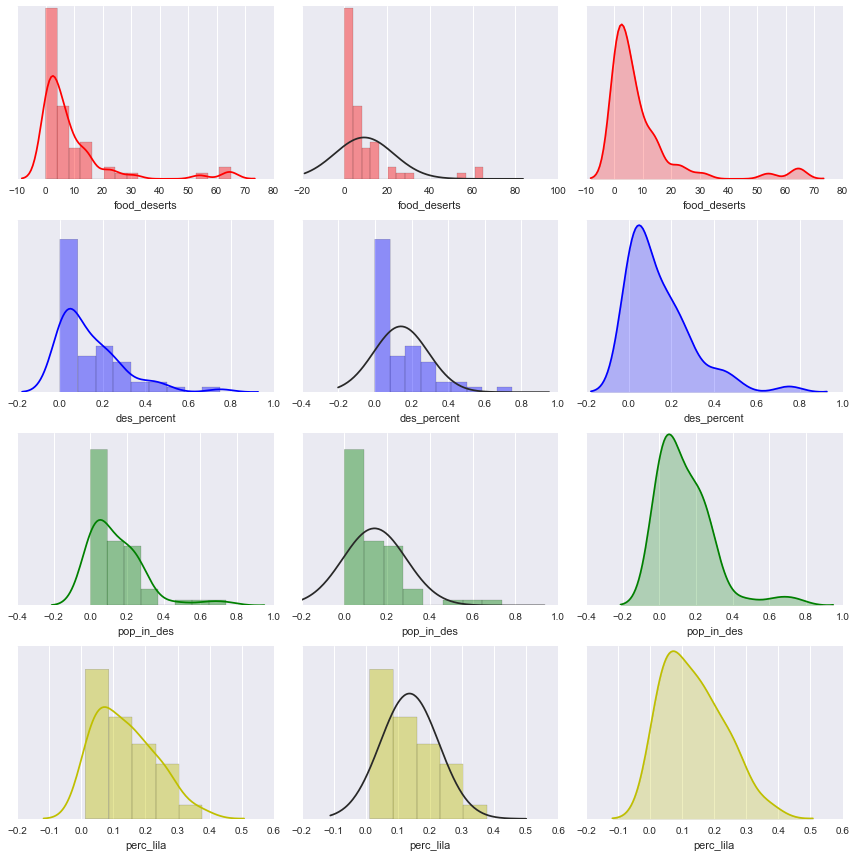

In [134]:
from scipy.stats import norm

f, axes = plt.subplots(4, 3, figsize=(12, 12))
sns.despine(left=True)

d = df['food_deserts']
d1 = df['des_percent']
d2 = df['pop_in_des']
d3 = df['perc_lila']

colors = ['r','b','g','y']
potential_ys = [d,d1,d2,d3]
ixs = range(len(potential_ys))
for var, c, i in zip(potential_ys,colors,ixs):
    sns.distplot(var, color=c, ax=axes[i, 0])
    sns.distplot(var, color=c, fit=norm, kde=False, ax=axes[i, 1])
    sns.distplot(var, hist=False, color=c, kde_kws={"shade": True}, ax=axes[i, 2])
    
plt.setp(axes, yticks=[])
plt.tight_layout()

For now, let's focus on pop_in_des as our y variable.

### Obtaining a broad look at Feature relationships

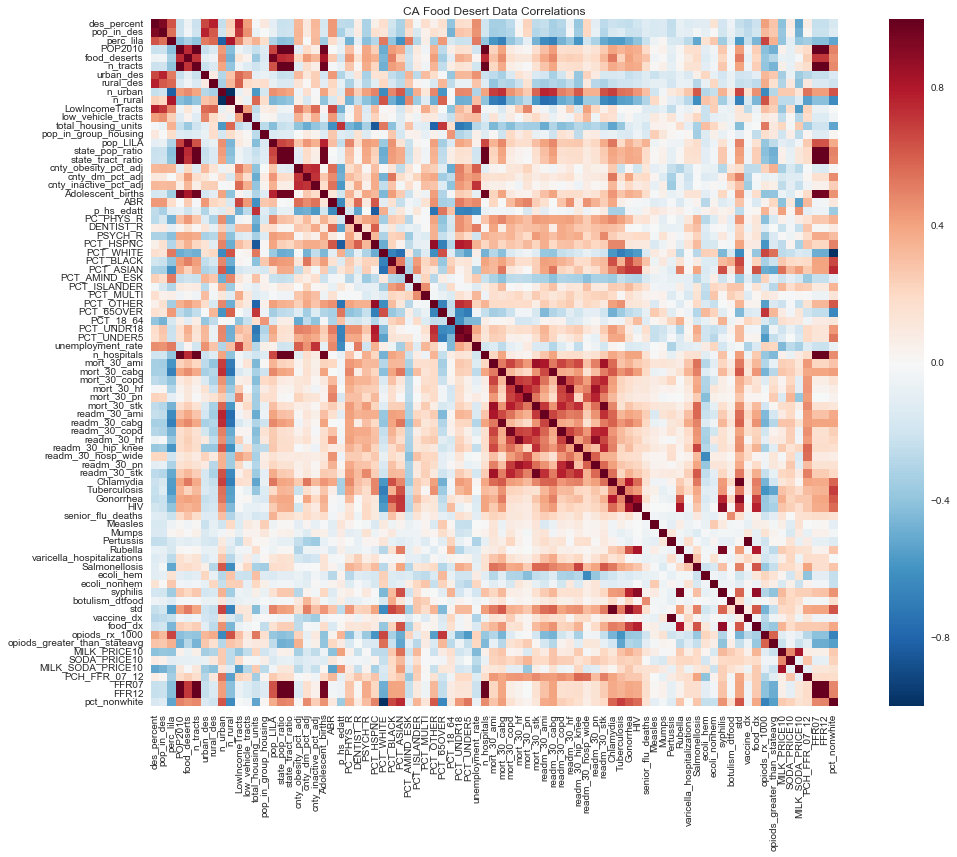

In [135]:
def standardize(variable):
    return (variable - np.mean(variable)) / np.std(variable)


data = standardize(df)

# generates a correllation matrix using pandas
corrmat = data.corr()

# Sets up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Drawa the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)
ax.set_title('CA Food Desert Data Correlations')
f.tight_layout()

There are a few things we should note in this graph:
* Not all hospitals care for stroke, CABG, or knee and hip surgery patients. Therefore we are likely to see less occurances of these features for smaller rural hospitals. Also, it is important to note that the hospital mortality and readmission feature Nan values were filled with 0. Therefore the correlations we are seeing with these features are likely just a reflection of county size (larger the counties have more hospitals).  

Despite this caveat we can still make some interesting inferences from correlations with pop_in_des (The proportion of county population living in a food desert census tract). Counties that are impacted the most by food deserts tend to be:
- More rural, low income, and less access to vehicles
- Have more obese, inactive, and younger residents
- Have higher adolescent birth rates
- Have lower education and employment rates
- Have less hospitals
- Have more opiod prescriptions


### A closer look at selected features

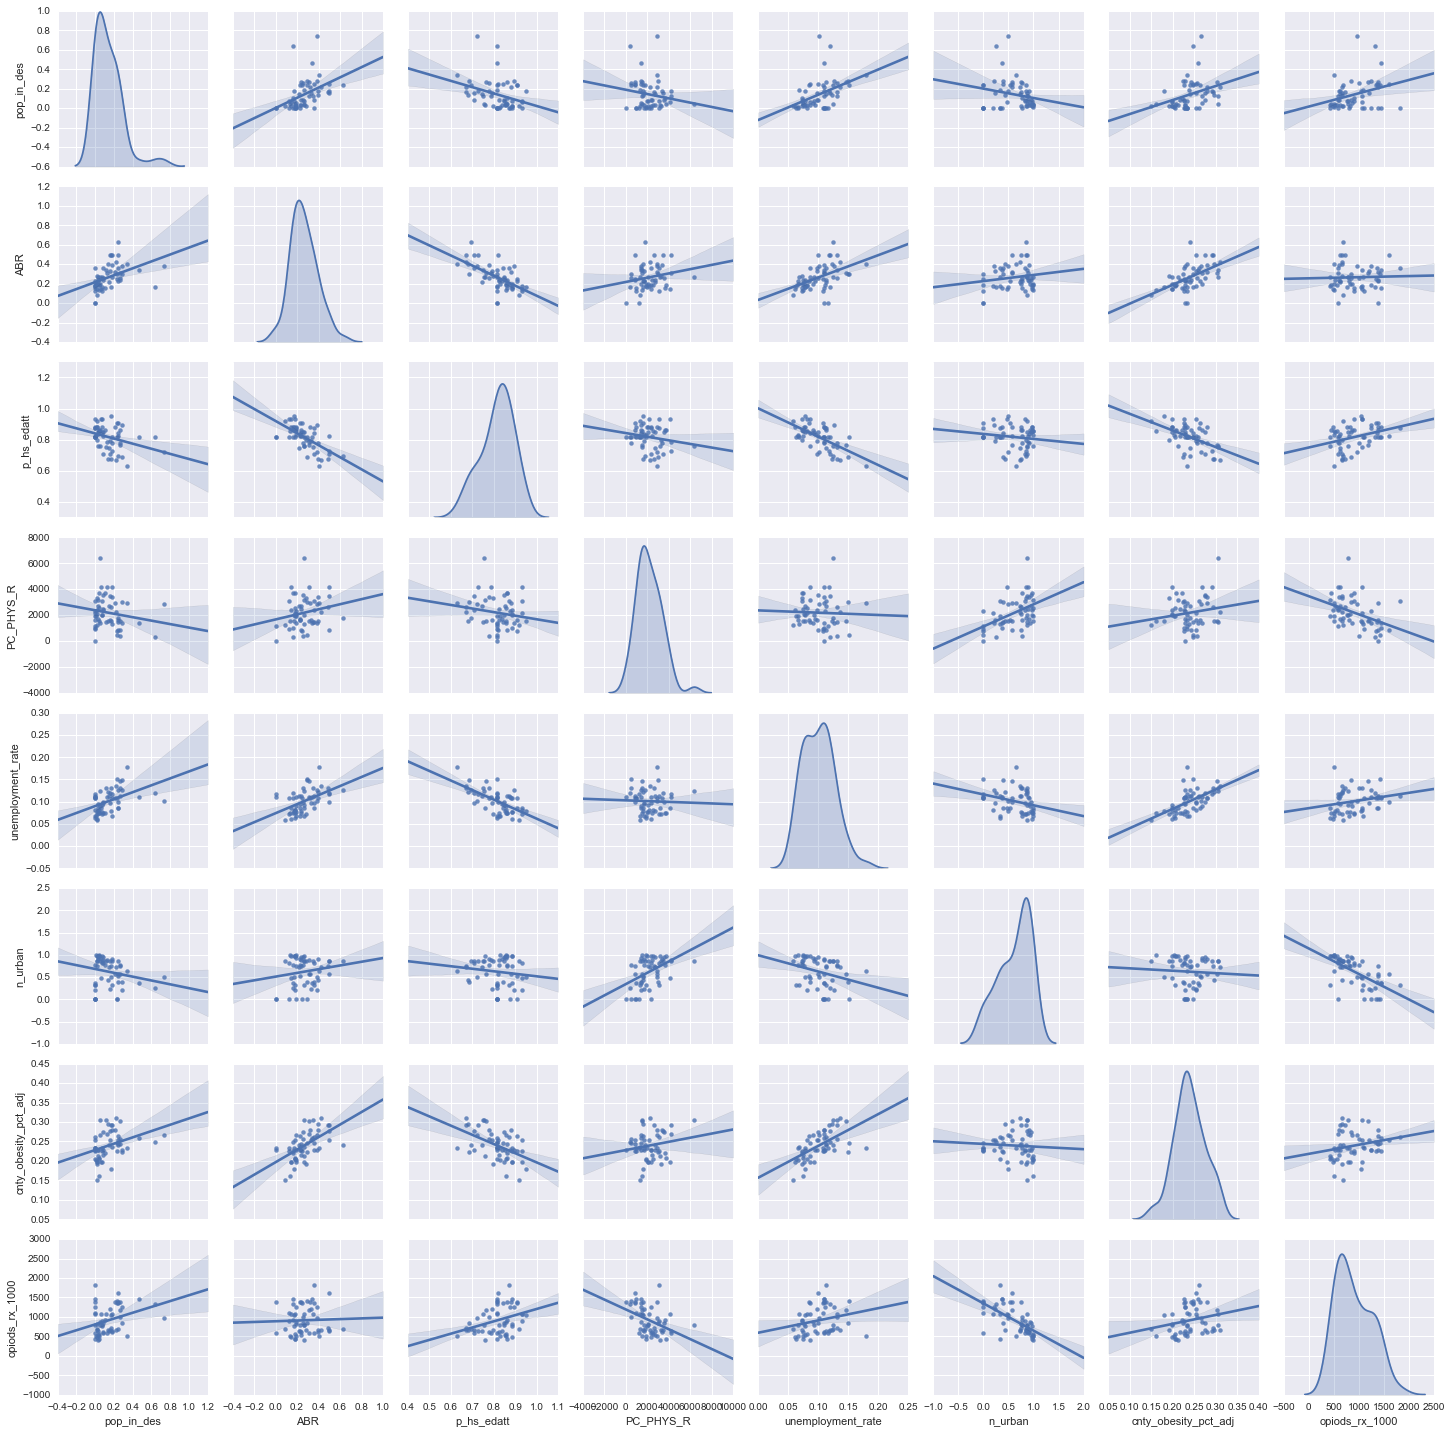

In [138]:
pairs=df[['pop_in_des','ABR','p_hs_edatt','PC_PHYS_R','unemployment_rate','n_urban','cnty_obesity_pct_adj','opiods_rx_1000']]
g = sns.pairplot(pairs, diag_kind="kde", kind='reg',
                 diag_kws=dict(shade=True))

___________
# An Example of Univariate Regression

## Goal
Identify characteristics of counties that are most effected by food deserts.
## Hypotheses 
Hypothesis 1: Counties with a greater percentage of citizens living in food deserts tend to also have a greater percentage of obese citizens.  

Hypothesis 2: County level obesity rate is a useful measure in predicting the percentage of citizens living in food deserts  

To test this hypothesis, I will assess if a correlation exists between these 2 features. I then will implement a univariate linear regression model to determine whether county-level obesity rates is a useful in predicting the proportion of citizens living in Census Tracts labeled as food deserts. 

* x = cnty_obesity_pct_adj: County obesity rates (age-adjusted)
* y = pop_in_des: Percentage of citizens living in Food deserts  (The proportion of county population living in a food desert census tract).

Below is a plot of the two features we have selected:

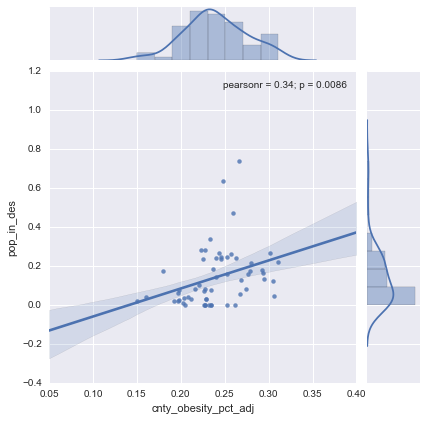

In [24]:
sns.jointplot(x='cnty_obesity_pct_adj', y='pop_in_des', data=df, kind='reg')

Correlation between two variables suggests that there is some sort of relationship between them. Correlation is assessed using the following formula:

$$ r = 1/n * {sum(xi - mean(x1) * (y-mean(y)) / std(xi * std(y)} $$

Values range from -1 to 1, and reflect the directionality and intensity of the relationship.
* values  > 0: suggests a positive correlation, as x increases y increases and as x deceases y decreases. The closer the values in to 1 the more dependent the features are on one another.
* values < 0:  suggests a negative correlation, as x increases y decreases, and vice versa. The closer the values in to -1 the more dependent the features are on one another.
* values = 0: suggests there is no relation between the two variables, meaning their values are completely independent of one another. 

If we do not standardize the variables we are comparing we will recieve a different measure of association called the covariance. This is less ideal for comparing two quantative features because it does not account for different scales. This measure is obtained by the formula below.

$$ cov(xi,y) = 1/n * sum(xi - mean(x1) * (y-mean(y)) $$


The functions below implement these formulas and compare the return result to scipy's pearsonr function which provides the correlation between two arrays, in addition to the p value.

In [275]:

def covariance(feat_1, feat_2, bias=0):
    observations = float(len(feat_1))
    return np.sum((feat_1 - np.mean(feat_1)) * (feat_2 - np.mean(feat_2)))/(observations-min(bias,1))

def standardize(feat):
    return (feat - np.mean(feat)) / np.std(feat)

def correlation(feat1,feat2,bias=0):
    return covariance(standardize(feat1), standardize(feat2),bias)


print ('Homemade correlation function: %0.5f' % (correlation(df['cnty_obesity_pct_adj'], 
                                                             df['pop_in_des'])))

print ('Result using Scipy, correlation and p-val: %0.5f & %0.5f' % pearsonr(df['cnty_obesity_pct_adj'],
                                                                                       df['pop_in_des']))


Homemade correlation function: 0.34204
Result using Scipy, correlation and p-val: 0.34204 & 0.00859


With a correlation of 0.34204, and a p value of 0.00859, we can state there is a statistically significant positive correlation between county diabetes rates and the percentage of county residents that live in food deserts. 

Now that we know there is some sort of relationship between these two features, lets now try to see how accurately we can predict the percentage of county residents living in food deserts when given county diabetes rates.

To do this we will use inivariate linear regression which utilizes the following formula:

$$ y = a + bX $$
$$ y = dependent$$
$$ X = explanatory$$
$$ a = bias\ (y\ intercept\ or\ the\ value\ of\ y\ when\ x=0.)$$

Lets use Statsmodels to implement our model

In [276]:
X=df['cnty_obesity_pct_adj']
y=df['pop_in_des']
X = sm.add_constant(X) # adds bias

lr_model1 = sm.OLS(y,X).fit()
lr_model2 = smf.ols(formula='pop_in_des ~ cnty_obesity_pct_adj', data=df).fit()

# The line below will provide identical output to our first model.
#lr_model2.summary() 
lr_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             pop_in_des   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     7.420
Date:                Tue, 09 Aug 2016   Prob (F-statistic):            0.00859
Time:                        20:14:30   Log-Likelihood:                 31.851
No. Observations:                  58   AIC:                            -59.70
Df Residuals:                      56   BIC:                            -55.58
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
const                   -0.2038      0.128     -1.592      0.117        -0.460     0.053
cnty_obesity_pct_adj     1.4398      0.529      2.724      0.009         0.381     2.499
==============================================================================
Omnibus:                       35.873   Durbin-Watson:                   2.160
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.424
Skew:                           1.902   Prob(JB):                     1.04e-19
Kurtosis:                       7.659   Cond. No.                         29.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Statsmodels OLS summary output
### First Table
##### Baseline model information
• Dep. Variable - The model's target variable   
• Model: The type of model made (OLS ='s ordinary least squares)   
• No. Observations: The number of observations the model was trained on.   
• DF Residuals: The number of observations minus the number of parameters. We have 56 because we passed in 58 observations, and 2 parameters (obesity rates, and contant). 58-2 = 56   
• DF Model: The number of explanatory variables, excluding the constant.    
##### Goodness of model fit
• R-squared: Also reffered to as the coefficient of determination, and reflects how close the data are to the fitted regression line. It signifies how much more variance the model explains in comparison what is unexplained by the mean.    
• Adj. R-squared: The adjusted R-squared is a modified version of R-squared that has been adjusted for the number of predictors in the model. The adjusted R-squared increases only if the new term improves the model more than would be expected by chance. It decreases when a predictor improves the model by less than expected by chance. ( http://blog.minitab.com/blog/adventures-in-statistics/multiple-regession-analysis-use-adjusted-r-squared-and-predicted-r-squared-to-include-the-correct-number-of-variables)    
• F-statistic: Reflects whether the explanatory variables coefficients are different from zero. This becomes more important in multivariate regression. The high values suggests strong predictors.     
• Prob (F-statistic): This is the probability that you got that F-statistic was due to chance. Ideally this value should be less than a predefined significance level, such as 0.05.    
• AIC: This is the Akaike Information Criterion, which evaluates model complexity. Lesser is better. Becomes useful during model comparison.  
• BIC: This is the Bayesian Information Criterion. Similiar to AIC, but penalizes models with high paramaters more severly.   

### Second Table
##### Explanatory Variable Statistics
• coef: The estimated coefficient of the beta or the explantory variable. The coefficient of our explanatory variable, obesity rate, provides the change in county food desert prevelance for every unit increase in obesity rate. So if the coeff is 1.4398, and the constant is -0.2038, we would use the following formula to predict the percentage of county census tracts that are food deserts:   
$$ Percent of citizens in food desert = 1.4398 * x_{obesity prev} * -0.2038$$
• std err: The standard error of the explanatory variables coef, which reflects how confident we can be in the coef. Higher values reflect more uncertainty   
• t: The t-statistic value, reflects whether the coefficent is not zero.   
• P > |t|: The probability that the coefficient is different from zero just by chance    
• [95.0% Conf. Interval]: The upper and lower bounds of the coefficient estimate for a 95% confidence interval .

### Bottom Table
##### Model Residuals (difference between predictions an actual response variable values)
• Skewness: Refects the symmetry of residuals. Postive values = right tail, Negative values = left tail, Close to Zero values = symmetric. Here we see our residuals have a right tail.   
• Kurtosis: The distribution shape of the residuals. Postive values = high peak, Negative values = flat, Close to Zero values = bell shaped. Here we see our residuals have a high peak.   
• Omnibus D'Angostino's test: Mix of the tests above  
• Prob(Omnibus): The probility of the Omnibus statistic  
• Jarque-Bera: Also reflects skewness and kurtosis.  
• Prob (JB): The probility of the JB statistic.  
• Durbin-Watson: Tests for correlation among the residuals, used with Time series data.   
• Cond. No: This is a test for multicollinearity. Important in multivariate analysis.  

Statsmodels allows us to access the coeffcients with the params method, and the predictions of the model with .predict(data).  


In [277]:
print (lr_model1.params)
betas = np.array(lr_model1.params)
fitted_values =lr_model1.predict(X)

const                  -0.203794
cnty_obesity_pct_adj    1.439796
dtype: float64




Using our model's predictions we can calculate the R squared value manually as well. This is done by calculating the following: 

* Mean sum of squared errors - The unexplained variance of the proportion of county population living in a food desert (the sum of squared differences from the mean). 
  
$$ mean\ sum\ of\ squared\ errors = sum(dependent\ variable \ values - mean( dependent\ variable \ values )^2)$$
  
* Residual sum of squared errors - The residual sum of squares, the difference between the actual and predcicted values (regresion sum of squares) 
  
$$ Residual\ sum\ of\ squared\ errors = sum(actual \ values - predicted \ values )^2)$$
  
* R squared - the amount of variance explained by the model,  SSD - SSR / SSD
  
$$ R\ squared = (mean\ sum\ of\ squared\ errors - Residual\ sum\ of\ squared\ errors) / mean\ sum\ of\ squared\ errors )$$



In [278]:
mean_sum_squared_errors = np.sum((df['pop_in_des']-df['pop_in_des'].mean())**2)
regr_sum_squared_errors = np.sum((df['pop_in_des']-fitted_values)**2)
r2 = (mean_sum_squared_errors - regr_sum_squared_errors) / mean_sum_squared_errors
print("SSD = {}\nSSR = {}\nR2 = {}").format(mean_sum_squared_errors,regr_sum_squared_errors,r2)

SSD = 1.28232351825
SSR = 1.13230279992
R2 = 0.116991317861


Now that we have a sence of how good our model is, we should asses how we can improve it's performance. Below are some common causes of underperformance:

##### Outliers
Observations with dependent variable values that differ significantly from other observations with similar explanatory variable values. These observations will have large residuals in a residual plot.
##### Leverage
Observations with explanatory variable values that differ significantly from other observations. These observations will have disproportionate effects on coefficients.
##### Influence
Obsevations that have a significant impact on the outcome values due to one or both of the above.


Lets visualize our model in a dataframe and some plots to find problematic observations.

In [279]:
lr_pred = pd.DataFrame({'cnty_obesity_pct_adj':X['cnty_obesity_pct_adj'],'Predicted_Output(pop_in_des)':fitted_values,'Actual_Output(pop_in_des)':y})
lr_pred['mean'] = lr_pred['Actual_Output(pop_in_des)'].mean()
lr_pred.head()

,Actual_Output(pop_in_des),Predicted_Output(pop_in_des),cnty_obesity_pct_adj,mean
County,,,,
Alameda,0.037134,0.089924,0.204,0.141062
Alpine,0.000000,0.130238,0.232,0.141062
Amador,0.000000,0.124479,0.228,0.141062
Butte,0.268086,0.146076,0.243,0.141062
Calaveras,0.000000,0.160474,0.253,0.141062


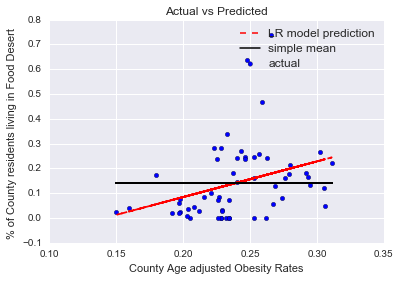

In [280]:

xval = lr_pred['cnty_obesity_pct_adj']
xp = lr_pred['Predicted_Output(pop_in_des)']
yval = lr_pred['Actual_Output(pop_in_des)']
m = lr_pred['mean']


fig, ax = plt.subplots()
ax.plot(xval, xp, 'k--', color='r',label='LR model prediction')
plt.scatter(xval, yval, label='actual')
ax.plot(xval, m, 'k', label='simple mean')

legend = ax.legend(loc='best', shadow=True)

frame = legend.get_frame()
frame.set_facecolor('0.90')

for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  
    
ax.set_xlabel('County Age adjusted Obesity Rates')
ax.set_ylabel('% of County residents living in Food Desert ')
plt.title('Actual vs Predicted')
plt.show()

The graph above compares our model's prediction compared to the a model that predicted the mean for every observation. We can see our model fits the data better than the mean, however it is still far from perfect. We can also see some outliers exist in the top right corner. These will need to be addresed to improve our models performance. But before we address these let's look at one more plot that can help us evalute our model that is called a residual plot.  It shows the difference between the actual and predicted values of the response variable (pop_in_des). 


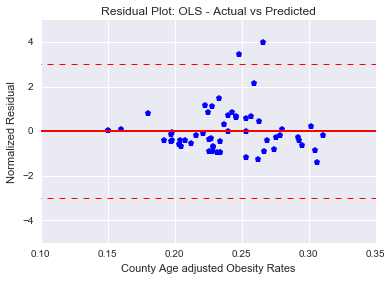

In [281]:
residuals = lr_pred['Actual_Output(pop_in_des)']-fitted_values
normalized_residuals = standardize(residuals)
x_range = [lr_pred['Actual_Output(pop_in_des)'].min(),lr_pred['Actual_Output(pop_in_des)'].max()]
residual_scatter_plot = plt.plot(lr_pred['cnty_obesity_pct_adj'], normalized_residuals,'bp')
mean_residual = plt.plot([int(x_range[0]),round(x_range[1],0)], [0,0],'-', color='red', linewidth=2)
upper_bound = plt.plot([int(x_range[0]),round(x_range[1],0)], [3,3], '--', color='red', linewidth=1)
lower_bound = plt.plot([int(x_range[0]),round(x_range[1],0)], [-3,-3],'--', color='red', linewidth=1)
plt.ylim([-5,5])
plt.xlim([0.10,0.35])
plt.title('Residual Plot: OLS - Actual vs Predicted')
plt.xlabel('County Age adjusted Obesity Rates')
plt.ylabel('Normalized Residual')
plt.show()

Our model's residual show there are a few points lying outside the normalized residual values. This reaffirms outliers are present within the response variable pop_in_des, which is contributing to poor performance.

We can also assess whether our explanatory variable contains outliers through a Influence plot. The plot depicts each observations residual (the difference between actual and predicted target variable value) on the y axis, and leverage on the x axis. Leverage can be though of as the distance between the observations explanatory variable value from other observations explanatory variable values. Statsmodels has a built in function to create this type of plot, which can be seen below.

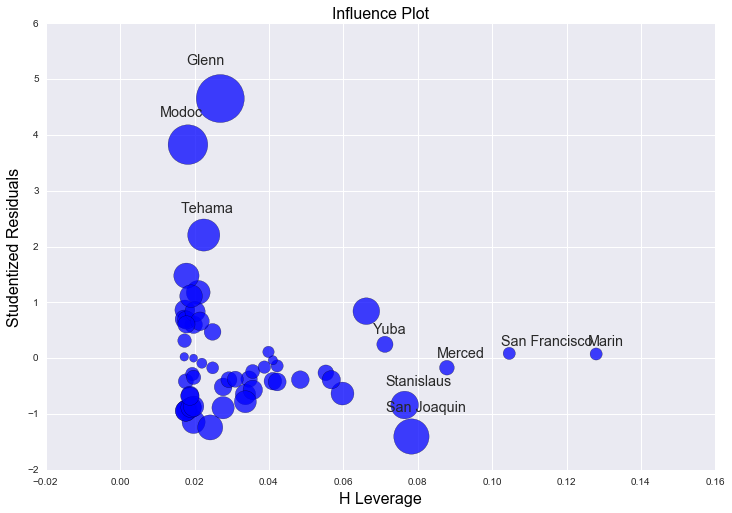

In [282]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(lr_model1, ax=ax, criterion="cooks")

Lets take a closer look at the influential observations identified above.

In [283]:
print "Dataset means: \n",df[['pop_in_des','cnty_obesity_pct_adj']].mean()
print "\nDataset std: \n",df[['pop_in_des','cnty_obesity_pct_adj']].std()

print "\nObs that contain target variable (pop_in_des) outliers: "
print "\nGlenn values : \n", df[['pop_in_des','cnty_obesity_pct_adj']].ix['Glenn']
print "\nModoc values : \n", df[['pop_in_des','cnty_obesity_pct_adj']].ix['Modoc']

print "\nObs that contain Explanatory variable (cnty_obesity_pct_adj) outliers: "
print "\nMarin values : \n", df[['pop_in_des','cnty_obesity_pct_adj']].ix['Marin']
print "\nSan Francisco values : \n", df[['pop_in_des','cnty_obesity_pct_adj']].ix['San Francisco']

Dataset means: 
pop_in_des              0.141062
cnty_obesity_pct_adj    0.239517
dtype: float64

Dataset std: 
pop_in_des              0.149990
cnty_obesity_pct_adj    0.035632
dtype: float64

Obs that contain target variable (pop_in_des) outliers: 

Glenn values : 
pop_in_des              0.73711
cnty_obesity_pct_adj    0.26600
Name: Glenn, dtype: float64

Modoc values : 
pop_in_des              0.636795
cnty_obesity_pct_adj    0.248000
Name: Modoc, dtype: float64

Obs that contain Explanatory variable (cnty_obesity_pct_adj) outliers: 

Marin values : 
pop_in_des              0.022285
cnty_obesity_pct_adj    0.150000
Name: Marin, dtype: float64

San Francisco values : 
pop_in_des              0.038215
cnty_obesity_pct_adj    0.160000
Name: San Francisco, dtype: float64


The following is another useful plotting function statsmodels offers called plot_regress_exog.
The left upper most plots our 2 variables with confidence intervals for the model. Again, we can see that there are 4 outliers, which lie outside the confidence intervals.  The right uppermost plot is another residual plot, similiar to the one we made above. The bottom plots are partial regression, and Component-Component plus Residual plot, which are relevant for multivariate models for trouble shooting different predictors. 

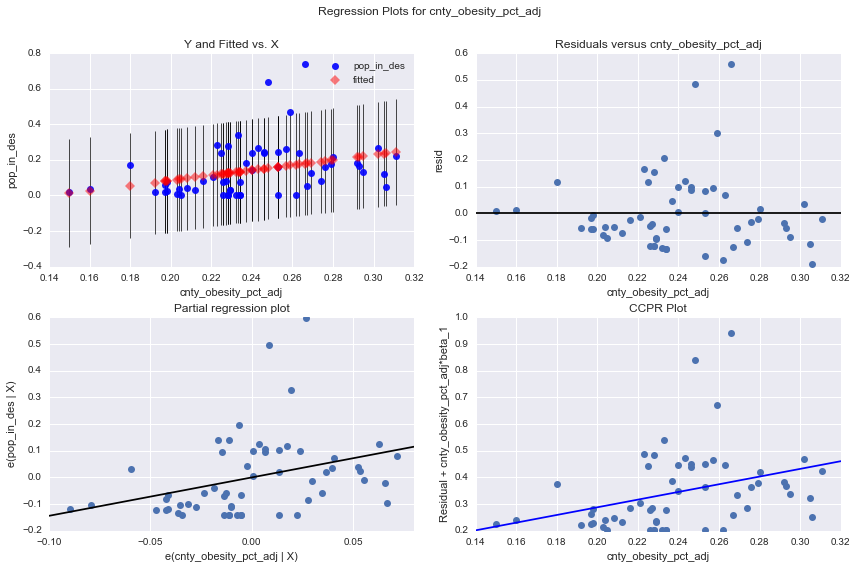

In [284]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(lr_model1, "cnty_obesity_pct_adj", fig=fig)

## Model adjustment

Lets try to improve our performance. To do so we will try two different methods:
* Robust Regression 
* Manual outlier exclusion

First lets make a robust model that weights observations to exclude outliers. This can be done using statsmodels rlm

In [285]:
from statsmodels.formula.api import rlm
robust_model = rlm("pop_in_des ~ cnty_obesity_pct_adj", data=df,
                      M=sm.robust.norms.TukeyBiweight(3)).fit(conv="weights")
print(robust_model.summary())

rbetas = np.array(robust_model.params)
rbetas

                    Robust linear Model Regression Results                    
Dep. Variable:             pop_in_des   No. Observations:                   58
Model:                            RLM   Df Residuals:                       56
Method:                          IRLS   Df Model:                            1
Norm:                   TukeyBiweight                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 09 Aug 2016                                         
Time:                        20:14:50                                         
No. Iterations:                    45                                         
                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept               -0.1918 

array([-0.19179074,  1.22152388])

We can see that our values have changed by excluding the outliers. Lets visually compare the two models below. 

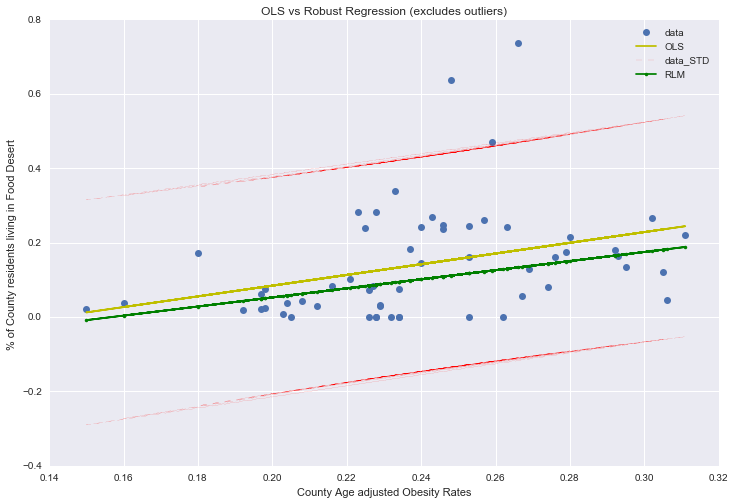

In [286]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(xval, yval, 'o',label="data")
prstd, iv_l, iv_u = wls_prediction_std(lr_model1)
ax.plot(xval, lr_model1.fittedvalues, 'y-', label="OLS")
ax.plot(xval, iv_u, color='r', linestyle='--', linewidth=.1)
ax.plot(xval, iv_l, 'r--', linestyle='--', linewidth=.1, label='data_STD')
ax.plot(xval, robust_model.fittedvalues, 'g.-', label="RLM")
ax.legend(loc="best")
ax.set_xlabel('County Age adjusted Obesity Rates')
ax.set_ylabel('% of County residents living in Food Desert ')
plt.title('OLS vs Robust Regression (excludes outliers)')

The plot above shows the influence the outliers had on our regression line, and how the robust model is better suited to predict observations lying within 3 standard deviations of the mean. Lets make a residual plot and calculate the robust models R squared for comparison.

In [287]:
weights = robust_model.weights
idx = weights > 0
X = robust_model.model.exog[idx.values]
ww = weights[idx] / weights[idx].mean()
hat_matrix_diag = ww*(X*np.linalg.pinv(X).T).sum(1)
resid = robust_model.resid
resid2 = resid**2
resid2 /= resid2.sum()
nobs = int(idx.sum())
hm = hat_matrix_diag.mean()
rm = resid2.mean()

In [288]:
mean_sum_squared_errors = np.sum((df['pop_in_des']-df['pop_in_des'].mean())**2)
regr_sum_squared_errors = np.sum((df['pop_in_des']-fitted_values)**2)
r2 = (mean_sum_squared_errors - regr_sum_squared_errors) / mean_sum_squared_errors
print("For OLS\nSSD = {}\nSSR = {}\nR2 = {}").format(mean_sum_squared_errors,regr_sum_squared_errors,r2)

mean_sum_squared_errors = np.sum((df['pop_in_des'].ix[idx]-df['pop_in_des'].ix[idx].mean())**2)
regr_sum_squared_errors = np.sum((df['pop_in_des'].ix[idx]-robust_model.fittedvalues)**2)
r2 = (mean_sum_squared_errors - regr_sum_squared_errors) / mean_sum_squared_errors
print("\nFor Robust Regression\nSSD = {}\nSSR = {}\nR2 = {}").format(mean_sum_squared_errors,regr_sum_squared_errors,r2)

For OLS
SSD = 1.28232351825
SSR = 1.13230279992
R2 = 0.116991317861

For Robust Regression
SSD = 0.53695315082
SSR = 0.469973020814
R2 = 0.124741106192


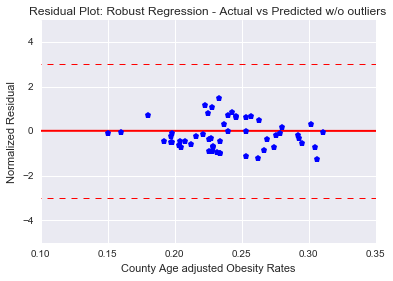

In [289]:
robnormalized_residuals = standardize(resid)
x_range = [lr_pred['Actual_Output(pop_in_des)'].ix[idx].min(),lr_pred['Actual_Output(pop_in_des)'].ix[idx].max()]
mean_residual = plt.plot([rm,0], '-', color='red', linewidth=2)
plt.plot(X[:,1], robnormalized_residuals[idx],'bp')
upper_bound = plt.plot([3,3], '--', color='red', linewidth=1)
lower_bound = plt.plot([-3,-3],'--', color='red', linewidth=1)
plt.ylim([-5,5])
plt.xlim([0.10,0.35])

plt.title('Residual Plot: Robust Regression - Actual vs Predicted w/o outliers')
plt.xlabel('County Age adjusted Obesity Rates')
plt.ylabel('Normalized Residual')
plt.show()

The plot below depicts the observations leverages by normalized residual values, allowing us to see which observations are having the strongest effects of model performance and estimated coefficients.

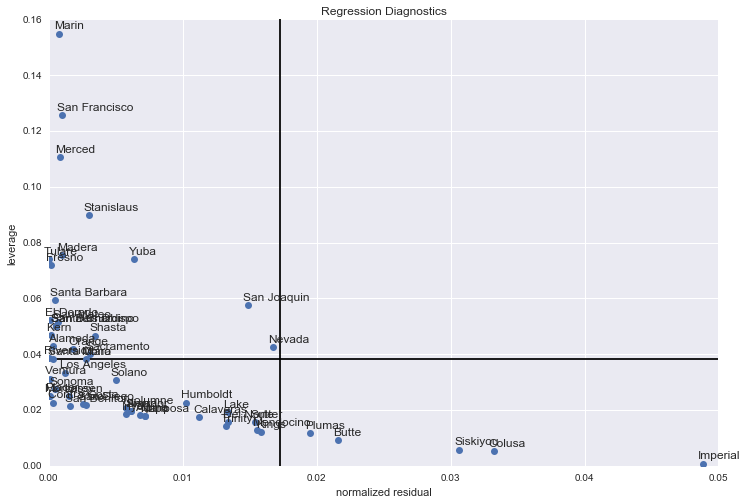

In [291]:
from statsmodels.graphics import utils
from statsmodels.compat import lzip

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(resid2[idx], hat_matrix_diag, 'o')
ax = utils.annotate_axes(range(nobs), labels=robust_model.model.data.row_labels[idx],
                    points=lzip(resid2[idx], hat_matrix_diag), offset_points=[(-5,5)]*nobs,
                    size="large", ax=ax)
ax.set_xlabel("normalized residual")
ax.set_ylabel("leverage")
ax.set_title("Regression Diagnostics")

ylim = ax.get_ylim()
ax.vlines(rm, *ylim)
xlim = ax.get_xlim()
ax.hlines(hm, *xlim)
ax.margins(0,0)

In [292]:
noouts = lr_pred[lr_pred['Actual_Output(pop_in_des)']<.33].index#['Actual_Output(pop_in_des)']

outs_model = smf.ols(formula='pop_in_des ~ cnty_obesity_pct_adj', data=df.ix[noouts]).fit()


outs_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             pop_in_des   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     10.98
Date:                Tue, 09 Aug 2016   Prob (F-statistic):            0.00168
Time:                        20:21:30   Log-Likelihood:                 55.705
No. Observations:                  54   AIC:                            -107.4
Df Residuals:                      52   BIC:                            -103.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept               -0.1494      0.080     -1.878      0.066        -0.309     0.010
cnty_obesity_pct_adj     1.0918      0.330      3.313      0.002         0.431     1.753
==============================================================================
Omnibus:                        4.056   Durbin-Watson:                   2.648
Prob(Omnibus):                  0.132   Jarque-Bera (JB):                3.186
Skew:                           0.468   Prob(JB):                        0.203
Kurtosis:                       2.267   Cond. No.                         29.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

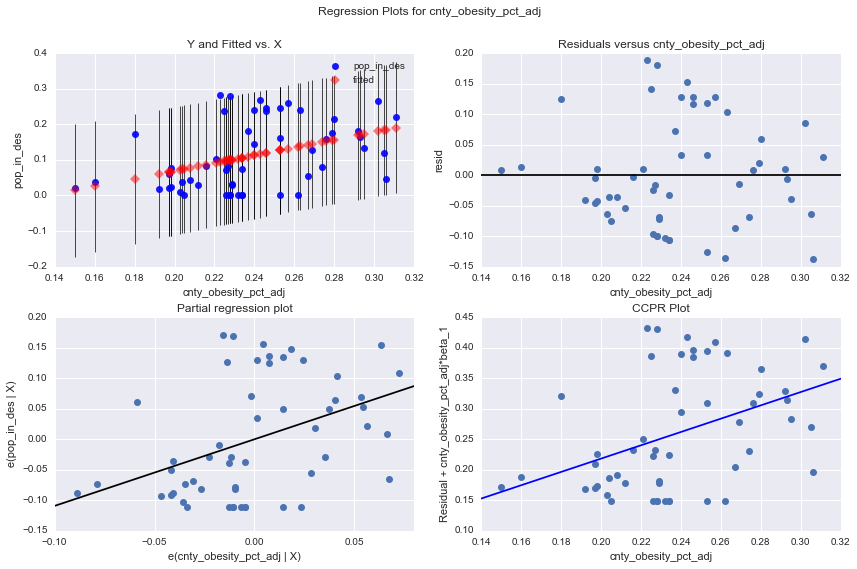

In [293]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(outs_model, "cnty_obesity_pct_adj", fig=fig)

In [294]:
mean_sum_squared_errors = np.sum((df['pop_in_des']-df['pop_in_des'].mean())**2)
regr_sum_squared_errors = np.sum((df['pop_in_des']-fitted_values)**2)
r2 = (mean_sum_squared_errors - regr_sum_squared_errors) / mean_sum_squared_errors
print("For OLS\nSSD = {}\nSSR = {}\nR2 = {}").format(mean_sum_squared_errors,regr_sum_squared_errors,r2)

mean_sum_squared_errors = np.sum((df['pop_in_des'].ix[idx]-df['pop_in_des'].ix[idx].mean())**2)
regr_sum_squared_errors = np.sum((df['pop_in_des'].ix[idx]-robust_model.fittedvalues)**2)
r2 = (mean_sum_squared_errors - regr_sum_squared_errors) / mean_sum_squared_errors
print("\nFor Robust Regression\nSSD = {}\nSSR = {}\nR2 = {}").format(mean_sum_squared_errors,regr_sum_squared_errors,r2)

mean_sum_squared_errors = np.sum((df.ix[noouts]['pop_in_des']-df.ix[noouts]['pop_in_des'].mean())**2)
regr_sum_squared_errors = np.sum((df.ix[noouts]['pop_in_des']-outs_model.fittedvalues)**2)
r2 = (mean_sum_squared_errors - regr_sum_squared_errors) / mean_sum_squared_errors
print("\nFor OLS W/o 4 outliers \nSSD = {}\nSSR = {}\nR2 = {}").format(mean_sum_squared_errors,regr_sum_squared_errors,r2)


For OLS
SSD = 1.28232351825
SSR = 1.13230279992
R2 = 0.116991317861

For Robust Regression
SSD = 0.53695315082
SSR = 0.469973020814
R2 = 0.124741106192

For OLS W/o 4 outliers 
SSD = 0.486485715161
SSR = 0.401697586767
R2 = 0.174286984698


Random Sample Consensus (RANSAC) algorithm: 

This method fits our model only to a subset of the data, it identifies as inliers. This is done by iteratively fitting the RANSACRegressor model the data that the user specifies in max_trials argument. With each iteration the model will identify inliers and outlier observations according to the Maximum residual set by the residual threshold argument. Observations meeting this threshold are classified as an inliers. The residual metric for which outliers are identified can be adjusted by the parameter residual_metric, but the default if the median absolut deviation of y. The algorithm is then terminated when the max_trials specifed is reached. 

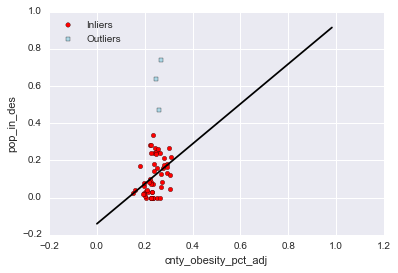

Estimated Coef: 1.074
Estimated Intercept: -0.141


In [295]:
from sklearn.linear_model import RANSACRegressor,LinearRegression

X=df[['cnty_obesity_pct_adj']].values
y=df['pop_in_des'].values

ransac = RANSACRegressor(LinearRegression(), 
                         max_trials=100, min_samples=20, 
                         residual_threshold=.20)

ransac.fit(X, y)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(0, 1, 1/float(len(X)))
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],c='red', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], c='lightblue', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black')
plt.xlabel('cnty_obesity_pct_adj')
plt.ylabel('pop_in_des')
plt.legend(loc='upper left')

plt.show()

print('Estimated Coef: %.3f' % ransac.estimator_.coef_[0])
print('Estimated Intercept: %.3f' % ransac.estimator_.intercept_)

In [296]:
from sklearn.metrics import r2_score
ransac_r2=r2_score(y[inlier_mask], ransac_pred[inlier_mask])

In [297]:
ransac_pred = ransac.estimator_.coef_[0] * df[['cnty_obesity_pct_adj']].values +ransac.estimator_.intercept_
inlier_mask = ransac.inlier_mask_
mean_sum_squared_errors = np.sum((df['pop_in_des']-df['pop_in_des'].mean())**2)
regr_sum_squared_errors = np.sum((df['pop_in_des']-fitted_values)**2)
r2 = (mean_sum_squared_errors - regr_sum_squared_errors) / mean_sum_squared_errors
print("For OLS\nSSD = {}\nSSR = {}\nR2 = {}").format(mean_sum_squared_errors,regr_sum_squared_errors,r2)

mean_sum_squared_errors = np.sum((df['pop_in_des'].ix[idx]-df['pop_in_des'].ix[idx].mean())**2)
regr_sum_squared_errors = np.sum((df['pop_in_des'].ix[idx]-robust_model.fittedvalues)**2)
r2 = (mean_sum_squared_errors - regr_sum_squared_errors) / mean_sum_squared_errors
print("\nFor Robust Regression\nSSD = {}\nSSR = {}\nR2 = {}").format(mean_sum_squared_errors,regr_sum_squared_errors,r2)

mean_sum_squared_errors = np.sum((df.ix[noouts]['pop_in_des']-df.ix[noouts]['pop_in_des'].mean())**2)
regr_sum_squared_errors = np.sum((df.ix[noouts]['pop_in_des']-outs_model.fittedvalues)**2)
r2 = (mean_sum_squared_errors - regr_sum_squared_errors) / mean_sum_squared_errors
print("\nFor OLS W/o 4 outliers \nSSD = {}\nSSR = {}\nR2 = {}").format(mean_sum_squared_errors,regr_sum_squared_errors,r2)

mean_sum_squared_errors = np.sum((X[inlier_mask]-np.mean(X[inlier_mask]))**2)
np.sum((X[inlier_mask]-np.mean(X[inlier_mask]))**2)
regr_sum_squared_errors = (ransac_r2 + mean_sum_squared_errors) * mean_sum_squared_errors
r2 = ransac_r2
print("\nFor RANSAC \nSSD = {}\nSSR = {}\nR2 = {}").format(mean_sum_squared_errors,regr_sum_squared_errors,r2)


For OLS
SSD = 1.28232351825
SSR = 1.13230279992
R2 = 0.116991317861

For Robust Regression
SSD = 0.53695315082
SSR = 0.469973020814
R2 = 0.124741106192

For OLS W/o 4 outliers 
SSD = 0.486485715161
SSR = 0.401697586767
R2 = 0.174286984698

For RANSAC 
SSD = 0.0711617090909
SSR = 0.0159363761088
R2 = 0.152784234766


Excluding observations should be avoided if possible. Excessive data tinkering and "stats-smithing" can result in misleading results instead of grounded in truth. 
_______
### Conclusion
* #### Counties with a greater percentage of citizens living in food deserts tend to also have a greater percentage of obese citizens.
* ####  County level obesity rate is a useful measure in predicting the percentage of citizens living in food deserts. In most California counties, for every 1% increase in county level diabetes rates, we can also expect to see approximately 1.09% more citizens living in Food deserts.

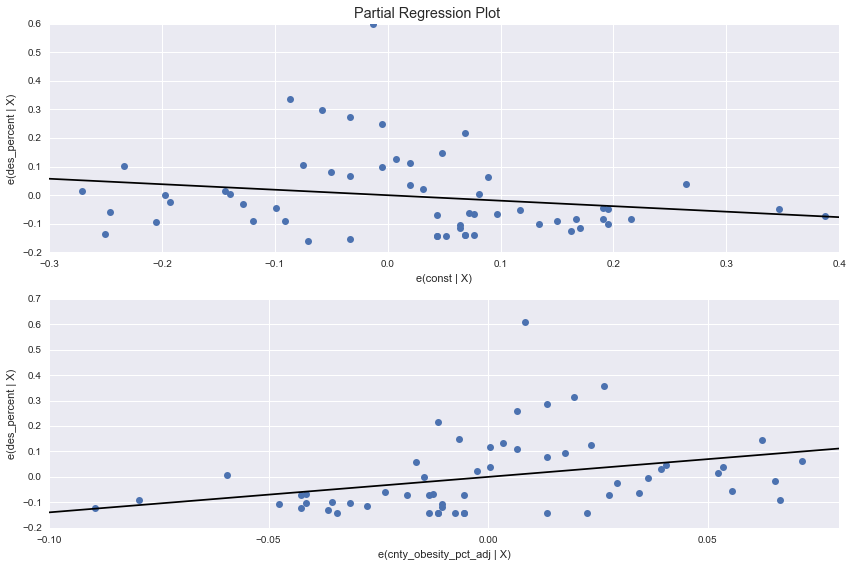

In [21]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(lr_model1, fig=fig)

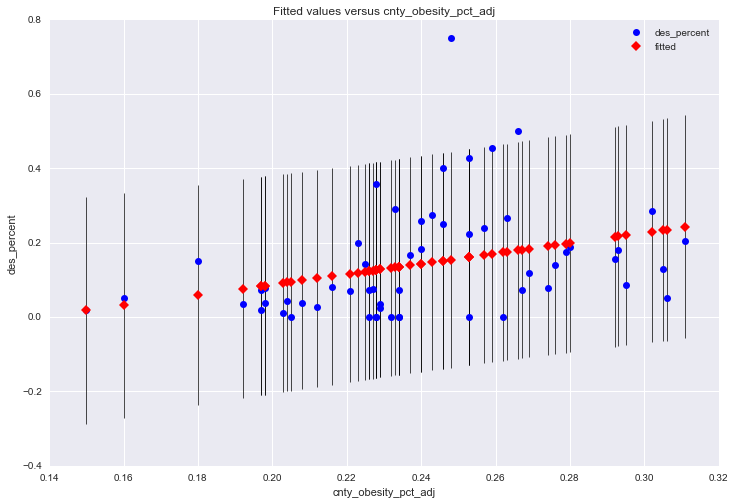

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_fit(lr_model1, "cnty_obesity_pct_adj", ax=ax)

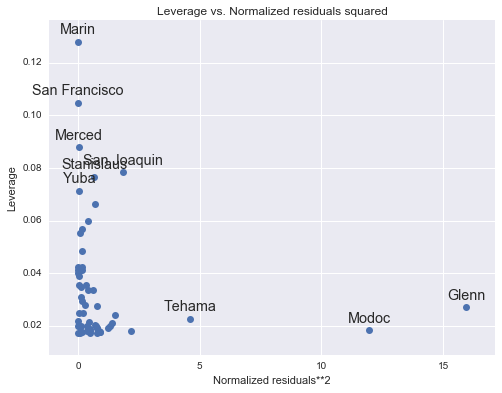

In [56]:
fig, ax = plt.subplots(figsize=(8,6))
fig = sm.graphics.plot_leverage_resid2(lr_model1, ax=ax)

In [24]:
print "\tDataset means: \n",df[['des_percent','cnty_obesity_pct_adj']].mean()
print "\n\tDataset std: \n",df[['des_percent','cnty_obesity_pct_adj']].std()
print "\n\tModoc values : \n", df[['des_percent','cnty_obesity_pct_adj']].ix['Modoc']
print "\n\tMarin values : \n", df[['des_percent','cnty_obesity_pct_adj']].ix['Marin']
print "\n\tSan Francisco values : \n", df[['des_percent','cnty_obesity_pct_adj']].ix['San Francisco']

	Dataset means: 
des_percent             0.142248
cnty_obesity_pct_adj    0.239517
dtype: float64

	Dataset std: 
des_percent             0.150671
cnty_obesity_pct_adj    0.035632
dtype: float64

	Modoc values : 
des_percent             0.750
cnty_obesity_pct_adj    0.248
Name: Modoc, dtype: float64

	Marin values : 
des_percent             0.018182
cnty_obesity_pct_adj    0.150000
Name: Marin, dtype: float64

	San Francisco values : 
des_percent             0.051282
cnty_obesity_pct_adj    0.160000
Name: San Francisco, dtype: float64


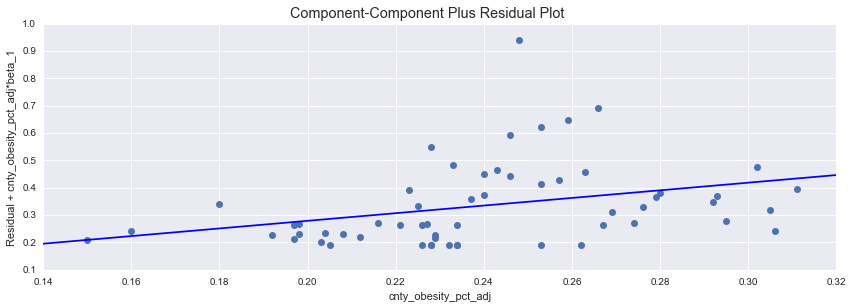

In [25]:
fig = plt.figure(figsize=(12, 8))
fig = sm.graphics.plot_ccpr_grid(lr_model1, fig=fig)

In [26]:
def order(frame,var):
    varlist =[w for w in frame.columns if w not in var]
    frame = frame[var+varlist]
    return frame 

def covariance(variable_1, variable_2, bias=0):
    observations = float(len(variable_1))
    return np.sum((variable_1 - np.mean(variable_1)) * (variable_2 - np.mean(variable_2)))/(observations-min(bias,1))

def standardize(variable):
    return (variable - np.mean(variable)) / np.std(variable)

def correlation(var1,var2,bias=0):
    return covariance(standardize(var1), standardize(var2),bias)





Minimizing the Cost Function
---
At the core of linear regression, there is the search for a line's equation that it is able to minimize the sum of the squared errors of the difference between the line's y values and the original ones.

In [27]:
def squared_cost(v,e):
    return np.sum((v-e)**2)

In [28]:
import random

def random_w( p ):
    return np.array([np.random.normal() for j in range(p)])

def hypothesis(X,w):
    return np.dot(X,w)

def loss(X,w,y):
    return hypothesis(X,w) - y

def squared_loss(X,w,y):
    return loss(X,w,y)**2

def gradient(X,w,y):
    gradients = list()
    n = float(len( y ))
    for j in range(len(w)):
        gradients.append(np.sum(loss(X,w,y) * X[:,j]) / n)
    return gradients

def update(X,w,y, alpha=0.01):
    return [t - alpha*g for t, g in zip(w, gradient(X,w,y))]

def optimize(X,y, alpha=0.01, eta = 10**-12, iterations = 1000):
    w = random_w(X.shape[1])
    path = list()
    for k in range(iterations):
        SSL = np.sum(squared_loss(X,w,y))
        new_w = update(X,w,y, alpha=alpha)
        new_SSL = np.sum(squared_loss(X,new_w,y))
        w = new_w
        if k>=5 and (new_SSL - SSL <= eta and new_SSL - SSL >= -eta):
            path.append(new_SSL)
            return w, path
        if k % (iterations / 20) == 0:
            path.append(new_SSL)    
    return w, path


In [29]:
observations = len(df)
X  = df['cnty_obesity_pct_adj'].values.reshape((observations,1))
# X should be always a matrix, never a vector
X = np.column_stack((X,np.ones(observations))) # We add the bias
y  = df['perc_lali'].values # y can be a vector

In [30]:
alpha = 0.048
w, path = optimize(X,y,alpha, eta = 10**-12, iterations = 100)
print ("These are our final coefficients: %s" % w)
print ("Obtained walking on this path of squared loss %s" % path)


These are our final coefficients: [-0.58730424138546522, 0.26771503450511069]
Obtained walking on this path of squared loss [170.85287758978117, 101.72122282984029, 60.658133393636817, 36.267305523278182, 21.779524094328707, 13.17398776852939, 8.0624073418015207, 5.0261786995715241, 3.2226745626727773, 2.1513883244290422, 1.5150273745439486, 1.1370048409160027, 0.91243105484860754, 0.77900329548177105, 0.69971478154460132, 0.65258409968293485, 0.62455465549380473, 0.60787104877814835, 0.59792670063414033, 0.59198537970441178]


In [31]:
X = df['cnty_obesity_pct_adj'].values
X  = df['cnty_obesity_pct_adj'].values.reshape((observations,1))
# X should be always a matrix, never a vector
X = np.column_stack((X,np.ones(observations))) # We add the bias

In [32]:
observations = len(df)
#variables = 'pop2010_in_des
standardization = StandardScaler()
Xst = standardization.fit_transform(X)
original_means = standardization.mean_
originanal_stds = standardization.std_
Xst = np.column_stack((Xst,np.ones(observations)))
y  = df['perc_lali'].values

/Users/desert/anaconda/envs/linreg/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function std_ is deprecated; Attribute ``std_`` will be removed in 0.19. Use ``scale_`` instead
  warnings.warn(msg, category=DeprecationWarning)


In [33]:
alpha = 0.02
w, path = optimize(Xst, y, alpha, eta = 10**-12, iterations = 200)
print ("These are our final standardized coefficients: " + ', '.join(map(lambda x: "%0.4f" % x, w)))

These are our final standardized coefficients: 0.0440, -0.0537, 0.1221


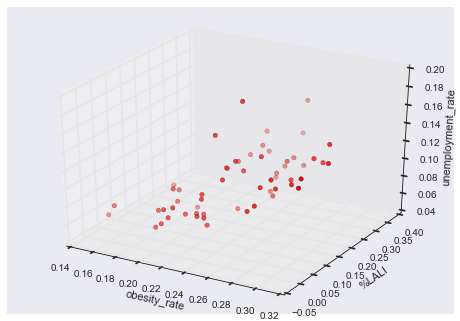

(58, 2)

In [34]:
z=df['unemployment_rate'].values
x=df['cnty_obesity_pct_adj'].values
y = df['perc_lali'].values
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')





ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel('obesity_rate')
ax.set_ylabel('%LALI')
ax.set_zlabel('unemployment_rate')

plt.show()
len(x)
np.shape(X)

In [35]:
from statsmodels.stats.anova import anova_lm
##############################################################################
# Multilinear regression model, calculating fit, P-values, confidence
# intervals etc.

# Convert the data into a Pandas DataFrame to use the formulas framework
# in statsmodels

# First we need to flatten the data: it's 2D layout is not relevent.
z=df['unemployment_rate'].values
x=df['cnty_obesity_pct_adj'].values
y = df['perc_lali'].values

# X = X.flatten()
# Y = Y.flatten()
# Z = Z.flatten()

data = pd.DataFrame({'obesity': x, 'fooddesert': y, '%urban': z})

# Fit the model
model = smf.ols("z ~ x + y", data).fit()

# Print the summary
print(model.summary())

print("\nRetrieving manually the parameter estimates:")
print(model._results.params)
# should be array([-4.99754526,  3.00250049, -0.50514907])

# Peform analysis of variance on fitted linear model
anova_results = anova_lm(model)

print('\nANOVA results')
print(anova_results)

                            OLS Regression Results                            
Dep. Variable:                      z   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     24.88
Date:                Mon, 08 Aug 2016   Prob (F-statistic):           2.01e-08
Time:                        11:53:11   Log-Likelihood:                 148.66
No. Observations:                  58   AIC:                            -291.3
Df Residuals:                      55   BIC:                            -285.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0041      0.017      0.234      0.8

________

## Baysian Approach - pymc3 

In [59]:
from pymc3 import  *

df = pd.read_csv('/Users/desert/desert_workspace/desert_data/fd_data.csv')
df = df.drop(['Unnamed: 0','State'], axis=1)
df['pct_nonwhite'] =  1 - df['PCT_WHITE'] 
df = df.drop(race+infx, axis=1)
cols = df.columns.tolist()

data = df.copy()
data = data[['pct_nonwhite', 'food_deserts']]#.astype(int)
data.columns=['x','y']

x=data['x'].values
y=data['y'].values
data=dict(x=x,y=y)
data

{'x': array([ 0.4834125 ,  0.3104    ,  0.05553333,  0.0965625 ,  0.0608    ,
         0.26745   ,  0.34015455,  0.211     ,  0.08314   ,  0.30679286,
         0.24816667,  0.19548   ,  0.32972   ,  0.21666667,  0.24879333,
         0.28806667,  0.10486   ,  0.287625  ,  0.45452222,  0.16276667,
         0.153475  ,  0.1298    ,  0.15491667,  0.34295   ,  0.09866667,
         0.15125   ,  0.2169875 ,  0.16198333,  0.0552    ,  0.35266296,
         0.09608333,  0.05936   ,  0.31228261,  0.35118125,  0.2683    ,
         0.27970385,  0.23263158,  0.4634625 ,  0.31498   ,  0.12374   ,
         0.3109    ,  0.2030125 ,  0.4607    ,  0.10546667,  0.0784875 ,
         0.0665    ,  0.088725  ,  0.35223333,  0.14063333,  0.20886667,
         0.25623333,  0.1241    ,  0.061175  ,  0.19783333,  0.13845   ,
         0.2652    ,  0.27345   ,  0.16903333]),
 'y': array([15,  0,  0, 14,  0,  1, 15,  3,  3, 31,  3,  8,  9,  1, 21,  7,  0,
         2, 65,  2,  1,  0,  5, 10,  3,  0,  7,  0,  3,  6,  6

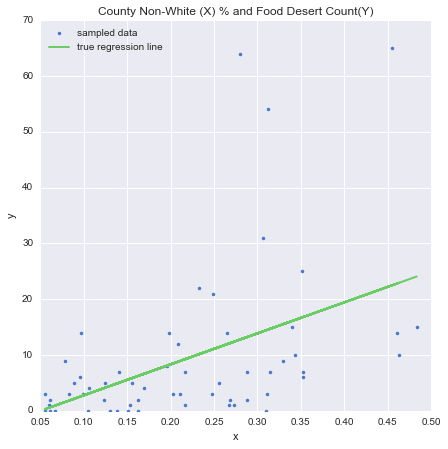

In [60]:

model1=smf.ols(formula='food_deserts ~ pct_nonwhite',data=df).fit()
model1.params
pred=model1.predict(pd.DataFrame(df['pct_nonwhite']))
true_regression_line = pred

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='County Non-White (X) % and Food Desert Count(Y)')
ax.plot(x, y, '.', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

In [61]:
with Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and 
    # and all its parameters are automatically added to our model.
    glm.glm('y ~ x', data)
    start = find_MAP()
    step = NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = sample(2000, step, progressbar=False) # draw 2000 posterior samples using NUTS sampling

Applied log-transform to sd and added transformed sd_log to model.


Bayesian Regression does not provide a singular best fit line. Instead it provides a posterior distribution of likely parameters. Below plots the posterior distribution of our parameters and the individual samples were drawn. I
(http://twiecki.github.io/blog/2013/08/12/bayesian-glms-1/)

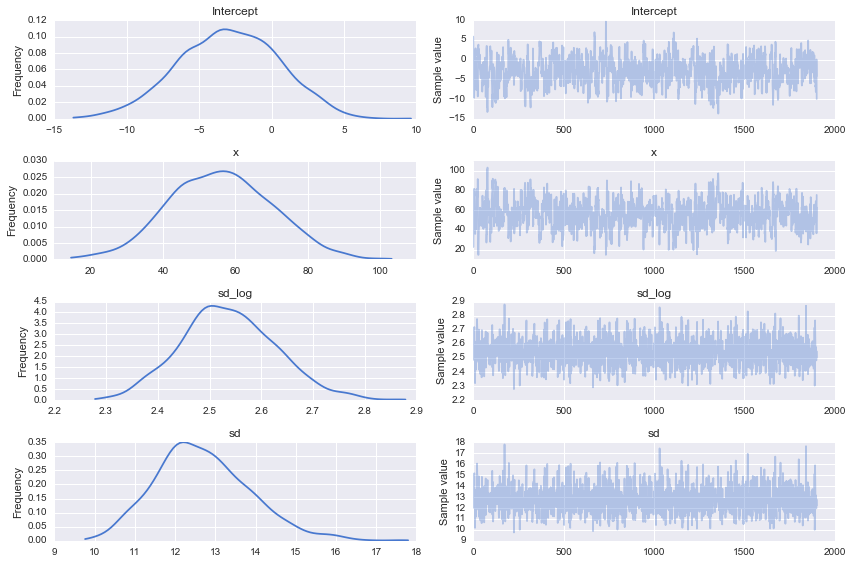

In [62]:
plt.figure(figsize=(7, 7))
traceplot(trace[100:])
plt.tight_layout();

In [63]:
model1.params
# x looks similiar to x's coef in linear model
# sd looks similiar to np.std(y), the std of target

Intercept       -2.775976
pct_nonwhite    55.518390
dtype: float64

The left side shows our marginal posterior -- for each parameter value on the x-axis we get a probability on the y-axis that tells us how likely that parameter value is.

There are a couple of things to see here. The first is that our sampling chains for the individual parameters (left side) seem well converged and stationary (there are no large drifts or other odd patterns).

Secondly, the maximum posterior estimate of each variable (the peak in the left side distributions) is very close to the true parameters used to generate the data (x is the regression coefficient and sigma is the standard deviation of our normal).

(http://twiecki.github.io/blog/2013/08/12/bayesian-glms-1/)

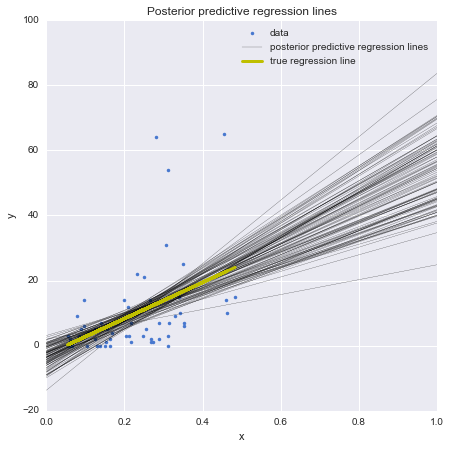

In [64]:
plt.figure(figsize=(7, 7))
plt.plot(x, y, '.', label='data')
glm.plot_posterior_predictive(trace, samples=100, 
                              label='posterior predictive regression lines')
plt.plot(x, true_regression_line, label='true regression line', lw=3., c='y')

plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y');

In the GLM we thus do not only have one best fitting regression line, but many. A posterior predictive plot takes multiple samples from the posterior (intercepts and slopes) and plots a regression line for each of them. 

As you can see, our estimated regression lines are very similar to the true regression line. But since we only have limited data we have uncertainty in our estimates, here expressed by the variability of the lines.
(http://twiecki.github.io/blog/2013/08/12/bayesian-glms-1/)
_______

Applied log-transform to lam and added transformed lam_log to model.


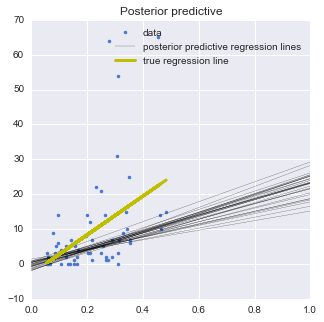

In [65]:
with Model() as model_robust:
    family = glm.families.StudentT()
    glm.glm('y ~ x', data, family=family)
    start = find_MAP()
    step = NUTS(scaling=start)
    trace_robust = sample(2000, step, progressbar=False)

plt.figure(figsize=(5, 5))
#plt.plot(x_out, y_out, 'x')
plt.plot(x, y, '.', label='data')

glm.plot_posterior_predictive(trace_robust,
                                 label='posterior predictive regression lines')
plt.plot(x, true_regression_line,
         label='true regression line', lw=3., c='y')
plt.legend();



Avoids outliers

In [208]:
import pymc3 as pm 

ur=pd.read_csv('/Users/desert/desert_workspace/desert_data/urban_rural_data.csv')
ur = ur.drop('Unnamed: 0', axis=1)

ur
county_names = ur.County.unique()
county_idx = ur.index
n_counties = len(ur.County.unique())
data = ur
data.describe()
len(county_idx.values)

8044

In [203]:
indiv_traces = {}
for county_name in county_names:
    # Select subset of data belonging to county
    c_data = data.ix[data.County == county_name]
    c_Rural = c_data.Rural
    c_fd = c_data.LILATracts_1And10.values
    
    with pm.Model() as individual_model:
        # Intercept prior (variance == sd**2)
        a = pm.Normal('alpha', mu=0, sd=100**2)
        # Slope prior
        b = pm.Normal('beta', mu=0, sd=100**2)
    
        # Model error prior
        eps = pm.Uniform('eps', lower=0, upper=100)
    
        # Linear model
        fd_est = a + b * c_Rural
    
        # Data likelihood
        radon_like = pm.Normal('radon_like', mu=fd_est, sd=eps, observed=c_fd)

        # Inference button (TM)!
        step = pm.NUTS()
        trace = pm.sample(2000, step=step, progressbar=True)
    
    # keep trace for later analysis
    indiv_traces[county_name] = trace

Applied interval-transform to eps and added transformed eps_interval to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 10.9 secApplied interval-transform to eps and added transformed eps_interval to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 63.3 secApplied interval-transform to eps and added transformed eps_interval to model.


KeyboardInterrupt: 

In [204]:
'test'

'test'

In [205]:
with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_alpha', mu=0., sd=100**2)
    sigma_a = pm.Uniform('sigma_alpha', lower=0, upper=100)
    mu_b = pm.Normal('mu_beta', mu=0., sd=100**2)
    sigma_b = pm.Uniform('sigma_beta', lower=0, upper=100)
    
    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=n_counties)
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal('beta', mu=mu_b, sd=sigma_b, shape=n_counties)
    
    # Model error
    eps = pm.Uniform('eps', lower=0, upper=100)
    
    # Model prediction of radon level
    # a[county_idx] translates to a[0, 0, 0, 1, 1, ...],
    # we thus link multiple household measures of a county
    # to its coefficients.
    fd_est = a[county_idx] + b[county_idx] * data.rural.values
    
    # Data likelihood
    fd_like = pm.Normal('radon_like', mu=fd_est, sd=eps, observed=datadata.LILATracts_1And10.values)

Applied interval-transform to sigma_alpha and added transformed sigma_alpha_interval to model.
Applied interval-transform to sigma_beta and added transformed sigma_beta_interval to model.
Applied interval-transform to eps and added transformed eps_interval to model.


IndexError: index 58 is out of bounds for axis 1 with size 58

In [71]:
import warnings
warnings.filterwarnings('ignore')

from collections import OrderedDict
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import fmin_powell
from scipy import integrate

import pymc3 as pm
import theano as thno
import theano.tensor as T

from IPython.html.widgets import interactive, fixed

# configure some basic options
sns.set(style="darkgrid", palette="muted")
pd.set_option('display.notebook_repr_html', True)
plt.rcParams['figure.figsize'] = 12, 8
rndst = np.random.RandomState(0)

In [72]:
def generate_data(n=20, p=0, a=1, b=1, c=0, latent_sigma_y=20):
    '''
    Create a toy dataset based on a very simple model that we might
    imagine is a noisy physical process:
        1. random x values within a range
        2. latent error aka inherent noise in y
        3. optionally create labelled outliers with larger noise

    Model form: y ~ a + bx + cx^2 + e

    NOTE: latent_sigma_y is used to create a normally distributed,
    'latent error' aka 'inherent noise' in the 'physical process'
    generating thses values, rather than experimental measurement error.
    Please don't use the returned `latent_error` values in inferential
    models, it's returned in e dataframe for interest only.
    '''

    df = pd.DataFrame({'x':rndst.choice(np.arange(100),n,replace=False)})

    ## create linear or quadratic model
    df['y'] = a + b*(df['x']) + c*(df['x'])**2

    ## create latent noise and marked outliers
    df['latent_error'] = rndst.normal(0,latent_sigma_y,n)
    df['outlier_error'] = rndst.normal(0,latent_sigma_y*10,n)
    df['outlier'] = rndst.binomial(1,p,n)

    ## add noise, with extreme noise for marked outliers
    df['y'] += ((1-df['outlier']) * df['latent_error'])
    df['y'] += (df['outlier'] * df['outlier_error'])

    ## round
    for col in ['y','latent_error','outlier_error','x']:
        df[col] = np.round(df[col],3)

    ## add label
    df['source'] = 'linear' if c == 0 else 'quadratic'

    ## create simple linspace for plotting true model
    plotx = np.linspace(df['x'].min() - np.ptp(df['x'])*.1
                        ,df['x'].max() + np.ptp(df['x'])*.1, 100)
    ploty = a + b*plotx + c*plotx**2
    dfp = pd.DataFrame({'x':plotx, 'y':ploty})

    return df, dfp


def interact_dataset(n=20, p=0, a=-30, b=5, c=0, latent_sigma_y=20):
    '''
    Convenience function:
    Interactively generate dataset and plot
    '''

    df, dfp = generate_data(n, p, a, b, c, latent_sigma_y)

    g = sns.FacetGrid(df, size=8, hue='outlier', hue_order=[True,False]
                    ,palette=sns.color_palette('Set1'), legend_out=False)

    _ = g.map(plt.errorbar, 'x', 'y', 'latent_error', marker="o"
              ,ms=10, mec='w', mew=2, ls='', elinewidth=0.7).add_legend()

    _ = plt.plot(dfp['x'], dfp['y'], '--', alpha=0.8)

    plt.subplots_adjust(top=0.92)
    _ = g.fig.suptitle('Sketch of Data Generation ({})'.format(df['source'][0])
                       ,fontsize=16)


def plot_datasets(df_lin, df_quad, dfp_lin, dfp_quad):
    '''
    Convenience function:
    Plot the two generated datasets in facets with generative model
    '''

    df = pd.concat((df_lin, df_quad), axis=0)
    dfp_lin, dfp_quad

    g = sns.FacetGrid(col='source', hue='source', data=df, size=6
                      ,sharey=False, legend_out=False)

    _ = g.map(plt.scatter, 'x', 'y', alpha=0.7, s=100, lw=2, edgecolor='w')

    _ = g.axes[0][0].plot(dfp_lin['x'], dfp_lin['y'], '--', alpha=0.6)
    _ = g.axes[0][1].plot(dfp_quad['x'], dfp_quad['y'], '--', alpha=0.6)


def plot_traces(traces, retain=1000):
    '''
    Convenience function:
    Plot traces with overlaid means and values
    '''

    ax = pm.traceplot(traces[-retain:], figsize=(12,len(traces.varnames)*1.5),
        lines={k: v['mean'] for k, v in pm.df_summary(traces[-retain:]).iterrows()})

    for i, mn in enumerate(pm.df_summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')


def create_poly_modelspec(k=1):
    '''
    Convenience function:
    Create a polynomial modelspec string for patsy
    '''
    return ('y ~ 1 + x ' + ' '.join(['+ np.power(x,{})'.format(j)
                                     for j in range(2,k+1)])).strip()


def run_models(df, upper_order=5):
    '''
    Convenience function:
    Fit a range of pymc3 models of increasing polynomial complexity.
    Suggest limit to max order 5 since calculation time is exponential.
    '''

    models, traces = OrderedDict(), OrderedDict()

    for k in range(1,upper_order+1):

        nm = 'k{}'.format(k)
        fml = create_poly_modelspec(k)

        with pm.Model() as models[nm]:

            print('\nRunning: {}'.format(nm))
            pm.glm.glm(fml, df, family=pm.glm.families.Normal())

            start_MAP = pm.find_MAP(fmin=fmin_powell, disp=False)
            traces[nm] = pm.sample(2000, start=start_MAP, step=pm.NUTS(), progressbar=True)

    return models, traces


def plot_posterior_cr(models, traces, rawdata, xlims,
                      datamodelnm='linear', modelnm='k1'):
    '''
    Convenience function:
    Plot posterior predictions with credible regions shown as filled areas.
    '''

    ## Get traces and calc posterior prediction for npoints in x
    npoints = 100
    mdl = models[modelnm]
    trc = pm.trace_to_dataframe(traces[modelnm][-1000:])
    trc = trc[[str(v) for v in mdl.cont_vars[:-1]]]

    ordr = int(modelnm[-1:])
    x = np.linspace(xlims[0], xlims[1], npoints).reshape((npoints,1))
    pwrs = np.ones((npoints,ordr+1)) * np.arange(ordr+1)
    X = x ** pwrs
    cr = np.dot(X,trc.T)

    ## Calculate credible regions and plot over the datapoints
    dfp = pd.DataFrame(np.percentile(cr,[2.5, 25, 50, 75, 97.5], axis=1).T
                         ,columns=['025','250','500','750','975'])
    dfp['x'] = x

    pal = sns.color_palette('Greens')
    f, ax1d = plt.subplots(1,1, figsize=(7,7))
    f.suptitle('Posterior Predictive Fit -- Data: {} -- Model: {}'.format(
                        datamodelnm, modelnm), fontsize=16)
    plt.subplots_adjust(top=0.95)

    ax1d.fill_between(dfp['x'], dfp['025'], dfp['975'], alpha=0.5
                      ,color=pal[1], label='CR 95%')
    ax1d.fill_between(dfp['x'], dfp['250'], dfp['750'], alpha=0.5
                      ,color=pal[4], label='CR 50%')
    ax1d.plot(dfp['x'], dfp['500'], alpha=0.6, color=pal[5], label='Median')
    _ = plt.legend()
    _ = ax1d.set_xlim(xlims)
    _ = sns.regplot(x='x', y='y', data=rawdata, fit_reg=False
                   ,scatter_kws={'alpha':0.7,'s':100, 'lw':2,'edgecolor':'w'}, ax=ax1d)


In [75]:
data = df.copy()
data = data[['pct_nonwhite', 'food_deserts']]#.astype(int)
data.columns=['x','y']

# x=data['x'].values
# y=data['y'].values
# data=dict(x=x,y=y)
data

,x,y
0,0.483413,15
1,0.310400,0
2,0.055533,0
3,0.096562,14
4,0.060800,0
5,0.267450,1
6,0.340155,15
7,0.211000,3
8,0.083140,3
9,0.306793,31


In [99]:
latent_sigma_y = 20
n = len(data)
p=0.05
c=0
a=1
b=1
## create latent noise and marked outliers
data['latent_error'] = rndst.normal(0,latent_sigma_y,n)
data['outlier_error'] = rndst.normal(0,latent_sigma_y*10,n)
data['outlier'] = rndst.binomial(1,p,n)

## add noise, with extreme noise for marked outliers
#df['y'] += ((1-df['outlier']) * df['latent_error'])
#df['y'] += (df['outlier'] * df['outlier_error'])

## round
for col in ['y','latent_error','outlier_error','x']:
    data[col] = np.round(data[col],3)

## add label
data['source'] = 'linear' if c == 0 else 'quadratic'

## create simple linspace for plotting true model
plotx = np.linspace(data['x'].min() - np.ptp(data['x'])*.1
                    ,data['x'].max() + np.ptp(data['x'])*.1, 100)
ploty = a + b*plotx + c*plotx**2
dfp = pd.DataFrame({'x':plotx, 'y':ploty})

In [100]:
rndst.binomial(1,p,n)
latent_sigma_y

20

In [101]:
def interact_dataset(n=len(data), p=0, a=-30, b=5, c=0, latent_sigma_y=20, df=data, dfp=dfp):
    '''
    Convenience function:
    Interactively generate dataset and plot
    '''

    #df, dfp = generate_data(n, p, a, b, c, latent_sigma_y)

    g = sns.FacetGrid(df, size=8, hue='outlier', hue_order=[True,False]
                    ,palette=sns.color_palette('Set1'), legend_out=False)

    _ = g.map(plt.errorbar, 'x', 'y', 'latent_error', marker="o"
              ,ms=10, mec='w', mew=2, ls='', elinewidth=0.7).add_legend()

    _ = plt.plot(dfp['x'], dfp['y'], '--', alpha=0.8)

    plt.subplots_adjust(top=0.92)
    _ = g.fig.suptitle('Sketch of Data Generation ({})'.format(df['source'][0])
                       ,fontsize=16)

In [195]:

data = df.copy()
data = data[['pct_nonwhite', 'food_deserts','n_tracts','POP2010','County']]#.astype(int)
data.columns=['x','y','n','pop','County']
n_count_data = len(data)


def get_obs(ix, var, n_var):
    res = []
    for i in ix:
        res+=([1]*data[var].ix[i] + [0]*(data[n_var].ix[i] - data[var].ix[i]))
    return res

data['x_int'] = np.round(data['x'] * data['pop'])
eth = [get_obs([i],'x_int','pop') for i in list(data.index)]
tracts =[get_obs([i],'y','n') for i in list(data.index)]
tracts
t_df = pd.DataFrame([t for t in tracts]).T
t_df.columns = df.County

pd.pivot_table(data, ['x','POP2010'], index=['n'],
                     columns='County')
# data['x_int'] = np.round(data['x'] * data['pop'])
# data['sigma_y']=[get_obs([i],'y','n') for i in list(data.index)]
# # data['x_int'] = df['x'] * df['pop']
# data['sigma_x']=[get_obs([i],'x_int','pop') for i in list(data.index)]


x                                                              \
County   Alameda  Alpine    Amador     Butte Calaveras   Colusa Contra Costa   
n                                                                              
1            NaN  0.3104       NaN       NaN       NaN      NaN          NaN   
3            NaN     NaN       NaN       NaN       NaN      NaN          NaN   
4            NaN     NaN       NaN       NaN       NaN      NaN          NaN   
5            NaN     NaN       NaN       NaN       NaN  0.26745          NaN   
6            NaN     NaN       NaN       NaN       NaN      NaN          NaN   
7            NaN     NaN       NaN       NaN       NaN      NaN          NaN   
9            NaN     NaN  0.055533       NaN       NaN      NaN          NaN   
10           NaN     NaN       NaN       NaN    0.0608      NaN          NaN   
11           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
14           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
15           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
20           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
21           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
23           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
27           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
30           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
31           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
40           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
41           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
42           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
48           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
49           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
51           NaN     NaN       NaN  0.096562       NaN      NaN          NaN   
52           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
53           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
55           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
78           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
84           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
89           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
93           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
94           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
96           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
99           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
139          NaN     NaN       NaN       NaN       NaN      NaN          NaN   
151          NaN     NaN       NaN       NaN       NaN      NaN          NaN   
156          NaN     NaN       NaN       NaN       NaN      NaN          NaN   
173          NaN     NaN       NaN       NaN       NaN      NaN          NaN   
195          NaN     NaN       NaN       NaN       NaN      NaN          NaN   
199          NaN     NaN       NaN       NaN       NaN      NaN          NaN   
207          NaN     NaN       NaN       NaN       NaN      NaN     0.340155   
317          NaN     NaN       NaN       NaN       NaN      NaN          NaN   
360     0.483413     NaN       NaN       NaN       NaN      NaN          NaN   
368          NaN     NaN       NaN       NaN       NaN      NaN          NaN   
372          NaN     NaN       NaN       NaN       NaN      NaN          NaN   
453          NaN     NaN       NaN       NaN       NaN      NaN          NaN   
582          NaN     NaN       NaN       NaN       NaN      NaN          NaN   
627          NaN     NaN       NaN       NaN       NaN      NaN          NaN   
2334         Na

### interactive(interact_dataset, n=[5,50,5], p=[0,.5,.05], a=[-50,50]
            ,b=[-10,10], c=[-3,3], latent_sigma_y=[0,1000,50])

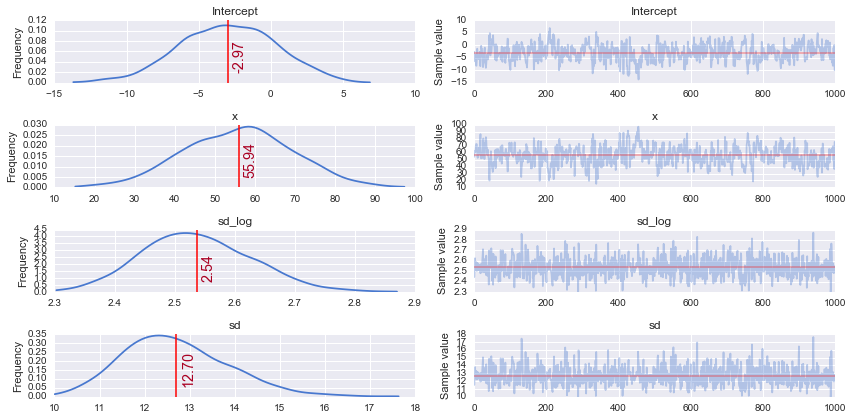

In [73]:
plot_traces(trace, retain=1000)

In [58]:
data = df.copy()
data = data[['pct_nonwhite', 'food_deserts']]
data.columns=['x','y']

## standardize (mean center and divide by 1 sd)
data = (data[['x','y']] - data[['x','y']].mean(0)) / data[['x','y']].std(0)
data['sigma_y'] = data['sigma_y'] / data['y'].std(0)
data['sigma_x'] = data['sigma_x'] / data['x'].std(0)


## create xlims ylims for plotting
xlims = (data['x'].min() - np.ptp(data['x'])/5
                 ,data['x'].max() + np.ptp(data['x'])/5)
ylims = (data['y'].min() - np.ptp(data['y'])/5
                 ,data['y'].max() + np.ptp(data['y'])/5)

## scatterplot the standardized data
g = sns.FacetGrid(data, size=8)
_ = g.map(plt.errorbar, 'x', 'y', 'sigma_y', 'sigma_x', marker="o", ls='')
_ = g.axes[0][0].set_ylim(ylims)
_ = g.axes[0][0].set_xlim(xlims)

plt.subplots_adjust(top=0.92)
_ = g.fig.suptitle('Scatterplot of ethnicity/food desert dataset after standardization', fontsize=16)


KeyError: 'sigma_y'

Lets look at the total percent of those living in a low access low income area.

Index([u'des_percent', u'perc_lali', u'urban_des', u'rural_des', u'n_urban',
       u'n_rural', u'LowIncomeTracts', u'low_vehicle_tracts',
       u'total_housing_units', u'pop_in_group_housing', u'pop_effected',
       u'state_pop_ratio', u'state_tract_ratio', u'cnty_obesity_pct_adj',
       u'cnty_dm_pct_adj', u'cnty_inactive_pct_adj', u'Adolescent_births',
       u'ABR', u'p_hs_edatt', u'PC_PHYS_R', u'DENTIST_R', u'PSYCH_R',
       u'PCT_WHITE', u'PCT_65OVER', u'PCT_18_64', u'PCT_UNDR18', u'PCT_UNDER5',
       u'unemployment_rate', u'n_hospitals', u'mort_30_ami', u'mort_30_cabg',
       u'mort_30_copd', u'mort_30_hf', u'mort_30_pn', u'mort_30_stk',
       u'readm_30_ami', u'readm_30_cabg', u'readm_30_copd', u'readm_30_hf',
       u'readm_30_hip_knee', u'readm_30_hosp_wide', u'readm_30_pn',
       u'readm_30_stk', u'std', u'vaccine_dx', u'food_dx', u'opiods_rx_1000',
       u'MILK_PRICE10', u'SODA_PRICE10', u'FFR07', u'pct_nonwhite'],
      dtype='object')

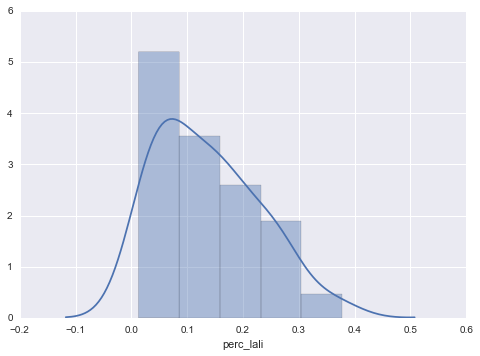

In [433]:
sns.distplot(df['perc_lali'])
df.columns

Sum of Squared Errors (SSE): 0


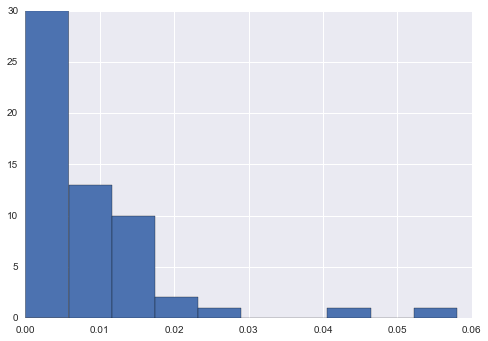

In [434]:
mean_expected_value = df['perc_lali'].mean()
Squared_errors = pd.Series(mean_expected_value - df['perc_lali'])**2
SSE = np.sum(Squared_errors)
print ('Sum of Squared Errors (SSE): %01.f' % SSE)
density_plot = Squared_errors.hist()


The plot shows how frequent certain errors are in respect of their values. Therefore, we can see that most errors are around zero (there is a high density around that value). Such a situation can be considered a good one, since in most cases the mean is a good approximation, but some errors are really very far from the zero and they can attain considerable values (don't forget that the errors are squared, anyway, so the effect is emphasized). When trying to  figure out such values, our approach will surely lead to a relevant error and we should find a way to minimize it using a more sophisticated approach.

Evidently, the mean is not a good representative of certain values, but it is certainly a good baseline to start from. Certainly, an important problem with the mean is
its being  xed, whereas the target variable is changeable. However, if we assume that the target variable changes because of the effect of some other variable we are measuring, then we can adjust the mean with respect to the variations in cause.

One improvement on our previous approach could be to build a mean conditional on certain values of another variable (or even more than one) actually related to our target, whose variation is somehow similar to the variation of the target one.  

Intuitively, if we know the dynamics we want to predict with our model, we can try to look for variables that we know can impact the answer values.   

In food deserts, we actually know that usually the larger a county population is,
the more food desert census tracts it will posess; however, this rule is just part of the story and the number of food deserts that are in a county is affected by many other considerations. For the moment, we will keep it simple and just assume that the obesity rate is a factor that negatively affects a counties well being, and consequently, results in more food deserts.  

Now, we have a variable that we know should change with our target and we just need to measure it and extend our initial formula based on constant values with something else.
In statistics, there is a measure that helps to measure how (in the sense of how much and in what direction) two variables relate to each other: 
#### correlation. ####
In correlation, a few steps are to be considered. First, your variables have to be standardized (or your result won't be a correlation but a covariation, a measure of association that is affected by the scale of the variables you are working with).

In statistical Z score standardization, you subtract from each variable its mean and then you divide the result by the standard deviation. The resulting transformed variable will have a mean of 0 and a standard deviation of 1 (or unit variance, since variance is the squared standard deviation).
The formula for standardizing a variable is as follows:

$$x = x-mean(x) / std(x)$$


After standardizing, you compare the squared difference of each variable with its own mean. If the two differences agree in sign, their multiplication will become positive (evidence that they have the same directionality); however, if they differ, the multiplication will turn negative. By summing all the multiplications between the squared differences, and dividing them by the number of observations, you will  finally get the correlation which will be a number ranging from -1 to 1.
The absolute value of the correlation will provide you with the intensity of the relation between the two variables compared, 1 being a sign of a perfect match and zero a sign of complete independence between them (they have no relation between them). The sign instead will hint at the proportionality; positive is direct (when one grows the other does the same), negative is indirect (when one grows, the other shrinks).


Covariance can be expressed as follows:

$$ cov(xi,y) = 1/n * sum(xi - mean(x1) * (y-mean(y)) $$

Whereas, Pearson's correlation can be expressed as follows:

$$ r = 1/n * {sum(xi - mean(x1) * (y-mean(y)) / std(xi * std(y)} $$

In [ ]:
def covariance(variable_1, variable_2, bias=0):
    observations = float(len(variable_1))
    return np.sum((variable_1 - np.mean(variable_1)) * (variable_2 - np.mean(variable_2)))/(observations-min(bias,1))

def standardize(variable):
    return (variable - np.mean(variable)) / np.std(variable)

def correlation(var1,var2,bias=0):
    return covariance(standardize(var1), standardize(var2),bias)

In [435]:
from scipy.stats.stats import pearsonr
print ('Our correlation estimation: %0.5f' % (correlation(df['cnty_obesity_pct_adj'], df['perc_lali'])))
print ('Correlation from Scipy pearsonr estimation: %0.5f' % pearsonr(df['cnty_obesity_pct_adj'], df['perc_lali'])[0])


Our correlation estimation: 0.33015
Correlation from Scipy pearsonr estimation: 0.33015


Our correlation estimation for the relation between the value of the target variable and the county unemployment rate in the area is  0.32989, which is positive and moderately strong, since the maximum positive score of a correlation is 1.0.

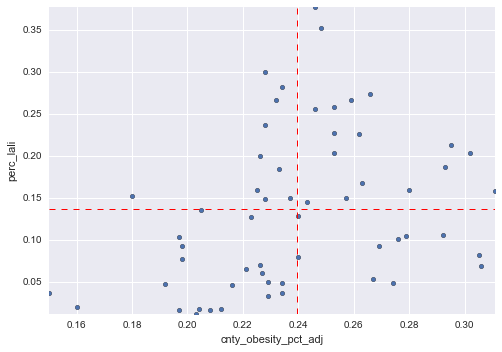

In [438]:
x_range = [df['cnty_obesity_pct_adj'].min(),df['cnty_obesity_pct_adj'].max()]
y_range = [df['perc_lali'].min(),df['perc_lali'].max()]
scatter_plot = df.plot(kind='scatter', x='cnty_obesity_pct_adj', y='perc_lali', xlim=x_range, ylim=y_range)
meanY = scatter_plot.plot(x_range, [df['perc_lali'].mean(),df['perc_lali'].mean()], '--' , color='red', linewidth=1)
meanX = scatter_plot.plot([df['cnty_obesity_pct_adj'].mean(),df['cnty_obesity_pct_adj'].mean()], y_range, '--', color='red', linewidth=1)


In [439]:
y = df['perc_lali']
X = df['cnty_obesity_pct_adj']
linear_regression = smf.ols(formula='perc_lali ~ cnty_obesity_pct_adj', data=df)
fitted_model = linear_regression.fit()
fitted_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              perc_lali   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     6.851
Date:                Mon, 08 Aug 2016   Prob (F-statistic):             0.0114
Time:                        02:41:37   Log-Likelihood:                 59.719
No. Observations:                  58   AIC:                            -115.4
Df Residuals:                      56   BIC:                            -111.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept               -0.0684      0.079     -0.865      0.391        -0.227     0.090
cnty_obesity_pct_adj     0.8557      0.327      2.617      0.011         0.201     1.511
==============================================================================
Omnibus:                        5.274   Durbin-Watson:                   1.732
Prob(Omnibus):                  0.072   Jarque-Bera (JB):                5.166
Skew:                           0.725   Prob(JB):                       0.0755
Kurtosis:                       2.808   Cond. No.                         29.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [440]:
print (fitted_model.params)
betas = np.array(fitted_model.params)
fitted_values = fitted_model.predict()

Intercept              -0.068440
cnty_obesity_pct_adj    0.855659
dtype: float64


Most of these statistics make sense when we are dealing with more than one predictor variable, so they will be discussed in the next notebook. Thus, for the moment, as we are working with a simple linear regression, the two measures that are worth examining closely are F-statistic and R-squared.
_______
* F-statistic is actually a test that doesn't tell you too much if you have enough observations and you can count on a minimally correlated predictor variable. Usually it shouldn't be much of a concern in a data science project.  

* R-squared is instead much more interesting because it tells you how much better your regression model is in comparison to a single mean. It does so by providing you with a percentage of the unexplained variance of a mean as a predictor that actually your model was able to explain.

If you want to compute the measure yourself, you just have to calculate the sum of squared errors of the mean of the target variable. That's your baseline of unexplained variance (the variability in the percentage of population living in a food desert that in our example we want to explain by a model). If from that baseline you subtract the sum of squared errors of your regression model, you will get the residual sum of squared errors, which can be compared using a division with your baseline:

In [441]:
mean_sum_squared_errors = np.sum((df['perc_lali']-df['des_percent'].mean())**2)
regr_sum_squared_errors = np.sum((df['perc_lali']-fitted_values)**2)
(mean_sum_squared_errors-regr_sum_squared_errors) / mean_sum_squared_errors

0.11248999922961715

In [442]:
mean_sum_squared_errors

0.4880235922972601

In [443]:
regr_sum_squared_errors

0.43312581877570633

a linear regression can always work within the range of values it learned from (this is called interpolation) but can provide correct values for its learning boundaries
(a different predictive activity called extrapolation) only in certain conditions.

Standard errors instead are very important because they signal a weak or unclear relationship between the predictor and the answer. You can notice this by dividing the standard error by its beta. If the ratio is 0.5 or even larger, then it's a clear sign that the model has little con dence that it provided you with the right coef cient estimates. Having more cases is always the solution because it can reduce the standard errors of the coef cients and improve our estimates; however, there are also other methods to reduce errors, such as removing the redundant variance present among the features by a principal component analysis or selecting a parsimonious set of predictors by greedy selections. All these topics will be discussed when we work with multiple predictors; at this point in the book, we will illustrate the remedies to such a problem.

In [444]:
regr_sum_squared_errors/ betas
#fitted_model.summary()
# betas
# lr_model1.params

array([-6.32857038,  0.50618979])

In [445]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              perc_lali   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     6.851
Date:                Mon, 08 Aug 2016   Prob (F-statistic):             0.0114
Time:                        02:42:15   Log-Likelihood:                 59.719
No. Observations:                  58   AIC:                            -115.4
Df Residuals:                      56   BIC:                            -111.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept               -0.0684      0.079     -0.865      0.391        -0.227     0.090
cnty_obesity_pct_adj     0.8557      0.327      2.617      0.011         0.201     1.511
==============================================================================
Omnibus:                        5.274   Durbin-Watson:                   1.732
Prob(Omnibus):                  0.072   Jarque-Bera (JB):                5.166
Skew:                           0.725   Prob(JB):                       0.0755
Kurtosis:                       2.808   Cond. No.                         29.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

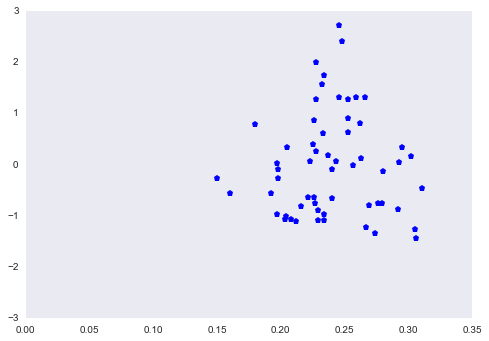

In [446]:
residuals = df['perc_lali']-fitted_values
normalized_residuals = standardize(residuals)
residual_scatter_plot = plt.plot(df['cnty_obesity_pct_adj'], normalized_residuals,'bp')
mean_residual = plt.plot([int(x_range[0]),round(x_range[1],0)], [0,0],'-', color='red', linewidth=2)
upper_bound = plt.plot([int(x_range[0]),round(x_range[1],0)], [3,3], '--', color='red', linewidth=1)
lower_bound = plt.plot([int(x_range[0]),round(x_range[1],0)], [-3,-3],'--', color='red', linewidth=1)
plt.grid()

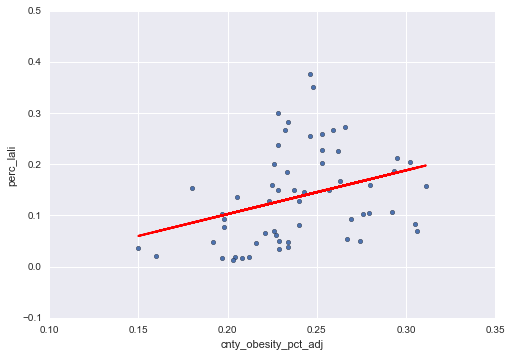

In [447]:
df.plot(kind='scatter', x='cnty_obesity_pct_adj', y='perc_lali')
plt.plot(pd.DataFrame(df['cnty_obesity_pct_adj']),fitted_values,c='red',linewidth=2)


In [ ]:
import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [ ]:
x_cols=[ 'percent_food_desert','unemployment_rate', 'unemployment_rate', 'cnty_obesity_pct_adj','cnty_inactive_pct','cnty_obesity_pct', 'PCT_18_64','p_hs_edatt','NUMGQTRS'] 
#x_cols=['PCT_18_64','p_hs_edatt','NUMGQTRS','cnty_inactive_pct'] 

data = df[x_cols]

model = forward_selected(data, 'percent_food_desert')

print model.model.formula

print model.rsquared_adj


In [ ]:
from sklearn.cross_validation import cross_val_score, ShuffleSplit
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
 
#Load boston housing dataset as an example
X =data.drop("pop2010_in_des",axis=1)
X=X.values
Y = data["pop2010_in_des"].values
names = data.columns
 
rf = RandomForestRegressor(n_estimators=20, max_depth=4)
scores = []
for i in range(X.shape[1]):
    score = cross_val_score(rf, X[:, i:i+1], Y, scoring="r2", cv=ShuffleSplit(len(X), 3, .3))
    scores.append((round(np.mean(score), 3), names[i]))
print sorted(scores, reverse=True)

In [ ]:
feats=pd.DataFrame(sorted(scores, reverse=True),columns=['importance','feature'])
feats.plot(kind='bar')
feats

In [ ]:

def plot_importances(X_train, importances, f_rank):
    '''
    :param X_train: Dataframe containing predictor variables of training set
    :param importances: List of feature importance, obtained from try_forest
    :param f_rank: Feature ranking, obtained from sort_features()
    :return: None, plot saved as 'Forest_feature_importances.png'
    '''
    plt.title('Feature Importances according to Random Forest')
    plt.bar(range(X_train.shape[1]), importances[indices], color='lightblue', align='center')
    plt.xticks(range(X_train.shape[1]), f_rank, rotation=45)
    plt.xlim([-1, X_train.shape[1]])
    plt.tight_layout()

In [ ]:
sns.barplot(x=feats['feature'][:5],y=feats['importance'][:5])

In [ ]:
# calculate the correlation matrix
corr_dataframe = data.corr()

# compute hierarchical cluster on both rows and columns for correlation matrix and plot heatmap 
def corr_heatmap(corr_dataframe):
    import scipy.cluster.hierarchy as sch
    
    corr_matrix = np.array(corr_dataframe)
    col_names = corr_dataframe.columns
    
    Y = sch.linkage(corr_matrix, 'single', 'correlation')
    Z = sch.dendrogram(Y, color_threshold=0, no_plot=True)['leaves']
    corr_matrix = corr_matrix[Z, :]
    corr_matrix = corr_matrix[:, Z]
    col_names = col_names[Z]
    im = plt.imshow(corr_matrix, interpolation='nearest', aspect='auto', cmap='bwr')
    plt.colorbar()
    plt.xticks(range(corr_matrix.shape[0]), col_names, rotation='vertical', fontsize=4)
    plt.yticks(range(corr_matrix.shape[0]), col_names[::-1], fontsize=4)
    
# plot
corr_heatmap(corr_dataframe)

In [ ]:

def remove_high_corr(corr_dataframe, thresh = 0.9):
    '''remove predictors with high pairwise correlation'''
    abs_corr = np.abs(corr_dataframe).as_matrix() # absolute correlation matrix
    col_names = list(corr_dataframe.columns)
    
    # set up diagonal to 0
    np.fill_diagonal(abs_corr, 0)
    
    print "Removed predictors (in order): \n"
    while np.max(abs_corr) >= thresh:
        i, j = np.unravel_index(abs_corr.argmax(), abs_corr.shape) # find maximum element
        # print abs_corr[i, j]
        rdx = which_to_remove(i, j, abs_corr)
        # remove corresponding predictor
        print col_names.pop(rdx)
        abs_corr = np.delete(abs_corr, rdx, 0)
        abs_corr = np.delete(abs_corr, rdx, 1)
        
    return col_names

def which_to_remove(i, j, abs_corr):
    '''compare two predictors and remove the one with higher abs correlation with other predictors'''
    i_absmean = np.mean(abs_corr[i, np.where(abs_corr[i,:] == 0)])
    j_absmean = np.mean(abs_corr[j, np.where(abs_corr[j,:] == 0)])
    
    return i if i_absmean > j_absmean else j

# remained predictors
col_remained = remove_high_corr(corr_dataframe)
data=data[col_remained]
corr_dataframe = data.corr()

corr_heatmap(corr_dataframe)

In [ ]:
col_remained = remove_high_corr(corr_dataframe)
data = df[col_remained]
corr_dataframe = data.corr()
corr_heatmap(corr_dataframe)

In [ ]:
corrmat = data.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Draw the heatmap using seaborn, and add a title to the plot
sns.heatmap(corrmat, vmax=.8, square=True)
ax.set_title('CA Food Desert Data Correlations')
f.tight_layout()

In [ ]:
model.summary()

In [ ]:

from bokeh.charts import Histogram
from bokeh.charts import defaults, vplot, hplot, show, output_file
from bokeh.io import output_notebook 
output_notebook()


# input options
hist = Histogram(df['pop2010_in_des'], title="df['pop2010_in_des']")
show(hist)
#df['pop2010_in_des']